# 1. Thêm các thư viện cần thiết

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.signal import spectrogram
from scipy.interpolate import griddata

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 2. Chuẩn bị dữ liệu

In [3]:
# Nhập dữ liệu từ file
def load_data(data_path):
    X_train = np.load(f'{data_path}/A01T_X.npy')
    y_train = np.load(f'{data_path}/A01T_Y.npy')
    X_test = np.load(f'{data_path}/A01E_X.npy')
    y_test = np.load(f'{data_path}/A01E_Y.npy')

    for i in range(2, 10, 1):
        xt = np.load(f'{data_path}/A0{i}T_X.npy')
        yt = np.load(f'{data_path}/A0{i}T_Y.npy')
        xv = np.load(f'{data_path}/A0{i}E_X.npy')
        yv = np.load(f'{data_path}/A0{i}E_Y.npy')

        X_train = np.concatenate([X_train, xt])
        y_train = np.concatenate([y_train, yt])
        X_test = np.concatenate([X_test, xv])
        y_test = np.concatenate([y_test, yv])

    # X_train = torch.from_numpy(X_train)
    # X_test = torch.from_numpy(X_test)
    # y_train = torch.from_numpy(y_train)
    # y_test = torch.from_numpy(y_test)

    return X_train, X_test, y_train, y_test

In [4]:
data_path = '/kaggle/input/eeg-preprocessed-data/IndividualData'

X_train, X_test, y_train, y_test = load_data(data_path)

In [5]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (2592, 22, 1875)
y_train shape: (2592,)
X_test shape: (2592, 22, 1875)
y_test shape: (2592,)


In [6]:
class EEGSpectralDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Lấy ảnh và nhãn
        image = self.X[idx]
        label = self.y[idx]

        # Áp dụng biến đổi
        if self.transform:
            image = self.transform(image)

        return torch.tensor(image, dtype=torch.float32).unsqueeze(0), torch.tensor(label, dtype=torch.long)

In [7]:
# Train and test dataset
train_dataset = EEGSpectralDataset(X_train, y_train)
test_dataset = EEGSpectralDataset(X_test, y_test)

In [8]:
# Train and test loader
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
train_dataset[0][0].shape

torch.Size([1, 22, 1875])

# 3. Xây dựng mô hình

In [10]:
class EEGNet(nn.Module):
    def __init__(self, num_classes, C=22, T=1875, F1=8, D=2, F2=16):
        super(EEGNet, self).__init__()
        
        # Block 1: Temporal Convolution
        self.conv1 = nn.Conv2d(1, F1, kernel_size=(1, 64), padding=(0, 32), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        self.depthwise_conv = nn.Conv2d(F1, F1 * D, kernel_size=(C, 1), groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.elu1 = nn.ELU()
        self.pool1 = nn.AvgPool2d(kernel_size=(1, 4))
        self.dropout1 = nn.Dropout(0.5)

        # Block 2: Separable Convolution
        self.separable_conv = nn.Conv2d(F1 * D, F2, kernel_size=(1, 16), padding=(0, 8), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F2)
        self.elu2 = nn.ELU()
        self.pool2 = nn.AvgPool2d(kernel_size=(1, 8))
        self.dropout2 = nn.Dropout(0.5)

        # Classification block
        self.fc = nn.Linear(F2 * (T // 32), num_classes)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.depthwise_conv(x)
        x = self.batchnorm2(x)
        x = self.elu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = self.separable_conv(x)
        x = self.batchnorm3(x)
        x = self.elu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Classification
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x

# Khởi tạo mô hình
num_classes = 4
eeg_net = EEGNet(num_classes=num_classes)
eeg_net = nn.DataParallel(eeg_net)
print(eeg_net)

DataParallel(
  (module): EEGNet(
    (conv1): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
    (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (depthwise_conv): Conv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), groups=8, bias=False)
    (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elu1): ELU(alpha=1.0)
    (pool1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (dropout1): Dropout(p=0.5, inplace=False)
    (separable_conv): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), bias=False)
    (batchnorm3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elu2): ELU(alpha=1.0)
    (pool2): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (dropout2): Dropout(p=0.5, inplace=False)
    (fc): Linear(in_features=928, out_features=4, bias=True)
  )
)


# 4. Huấn luyện và đánh giá mô hình

In [11]:
!pip install wandb

import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## 4.1 Định nghĩa các hàm chức năng

In [12]:
def evaluate_model(model, test_loader, criterion, device=None):
    if device is not None:
        model.to(device)

    model.eval() # Set the model to evaluation mode
    running_loss = 0.0

    true_labels = []
    predicted_labels = []

    # Use torch.no_grad() to disable gradient calculation during evaluation
    with torch.no_grad():
        for images, labels in tqdm(test_loader, unit='batch', desc='Evaluating'):
            if device is not None:
                images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = torch.argmax(outputs, dim=-1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(test_loader)
    accuracy = accuracy_score(true_labels, predicted_labels)

    labels = list(range(4))
    names = ['Left Hand', 'Right Hand', 'Foot', 'Tongue']
    classification_rep = classification_report(true_labels, predicted_labels, labels=labels, target_names=names, zero_division=0)

    print(f'\t---> Loss: {epoch_loss:.4f}\n\t---> Accuracy: {accuracy:.4f}\n\tClassification Report:\n{classification_rep}')

    return epoch_loss, accuracy

In [124]:
def train_model(model, train_loader, test_loader, criterion, optimizer, save_path, device=None, epochs=10, wandb_writer=None):
    if device is not None:
        model.to(device)
    model.train()

    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []

    best_acc = 0
    for epoch in range(epochs):
        running_loss = 0.0

        true_labels = []
        predicted_labels = []

        for images, labels in tqdm(train_loader, unit='batch', desc=f'Training epoch [{epoch+1}/{epochs}]'):
            if device is not None:
                images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            predicted = torch.argmax(outputs, dim=-1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        accuracy = accuracy_score(true_labels, predicted_labels)
        train_acc.append(accuracy)
        print(f'\t---> Loss: {epoch_loss:.4f}\n\t---> Accuracy: {accuracy:.4f}')

        test_loss, test_ac = evaluate_model(model, test_loader, criterion, device)
        model.train()
        test_losses.append(test_loss)
        test_acc.append(test_ac)

        if wandb_writer is not None:
            wandb_writer.log({
                "Train loss": epoch_loss,
                "Train accuracy": accuracy,
                "Test loss": test_loss,
                "Test accuracy": test_ac
            })

        if test_ac > best_acc:
            best_acc = test_ac
            torch.save(model.state_dict(), save_path)
            print('Model is saved to ', save_path)
            if wandb_writer is not None:
                wandb_writer.save(save_path)

    return train_losses, train_acc, test_losses, test_acc

## 4.2. Thực nghiệm trên mô hình

In [14]:
lr = 0.003
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(eeg_net.parameters(), lr=lr)

In [15]:
eeg_wan_writer = wandb.init(
    project="motor imagery",
    name="EEG-Net",
    config={
        "learning_rate": 0.003,
        "batch_size": 16,
        "epochs": 50,
    }
)

wandb: Currently logged in as: longluv1605 (longluv1605-institute-for-artificial-intelligence). Use `wandb login --relogin` to force relogin


In [16]:
save_path = '/kaggle/working/eeg.pth'
train_losses, train_acc, test_losses, test_acc = train_model(eeg_net, train_loader, test_loader, criterion, optimizer, save_path, device, epochs=50, wandb_writer=eeg_wan_writer)

Training epoch [1/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [1/50]: 100%|██████████| 162/162 [00:03<00:00, 41.62batch/s]


	---> Loss: 1.3657
	---> Accuracy: 0.3519


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.93batch/s]
wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


	---> Loss: 1.2637
	---> Accuracy: 0.4051
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.37      0.35      0.36       648
  Right Hand       0.32      0.29      0.30       648
        Foot       0.41      0.55      0.47       648
      Tongue       0.53      0.43      0.47       648

    accuracy                           0.41      2592
   macro avg       0.41      0.41      0.40      2592
weighted avg       0.41      0.41      0.40      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [2/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [2/50]: 100%|██████████| 162/162 [00:02<00:00, 79.76batch/s]


	---> Loss: 1.2459
	---> Accuracy: 0.4518


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.78batch/s]


	---> Loss: 1.1893
	---> Accuracy: 0.4618
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.40      0.29      0.34       648
  Right Hand       0.43      0.35      0.39       648
        Foot       0.45      0.56      0.50       648
      Tongue       0.54      0.63      0.58       648

    accuracy                           0.46      2592
   macro avg       0.45      0.46      0.45      2592
weighted avg       0.45      0.46      0.45      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [3/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [3/50]: 100%|██████████| 162/162 [00:02<00:00, 80.80batch/s]


	---> Loss: 1.1643
	---> Accuracy: 0.5004


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.96batch/s]


	---> Loss: 1.1316
	---> Accuracy: 0.5154
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.49      0.45      0.47       648
  Right Hand       0.46      0.40      0.43       648
        Foot       0.52      0.59      0.55       648
      Tongue       0.57      0.62      0.60       648

    accuracy                           0.52      2592
   macro avg       0.51      0.52      0.51      2592
weighted avg       0.51      0.52      0.51      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [4/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [4/50]: 100%|██████████| 162/162 [00:02<00:00, 78.46batch/s]


	---> Loss: 1.1042
	---> Accuracy: 0.5282


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 128.61batch/s]


	---> Loss: 1.1189
	---> Accuracy: 0.5189
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.54      0.40      0.46       648
  Right Hand       0.43      0.51      0.47       648
        Foot       0.53      0.55      0.54       648
      Tongue       0.60      0.61      0.61       648

    accuracy                           0.52      2592
   macro avg       0.52      0.52      0.52      2592
weighted avg       0.52      0.52      0.52      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [5/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [5/50]: 100%|██████████| 162/162 [00:02<00:00, 79.87batch/s]


	---> Loss: 1.0777
	---> Accuracy: 0.5397


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.06batch/s]


	---> Loss: 1.0667
	---> Accuracy: 0.5575
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.57      0.50      0.54       648
  Right Hand       0.49      0.44      0.46       648
        Foot       0.58      0.56      0.57       648
      Tongue       0.57      0.73      0.64       648

    accuracy                           0.56      2592
   macro avg       0.56      0.56      0.55      2592
weighted avg       0.56      0.56      0.55      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [6/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [6/50]: 100%|██████████| 162/162 [00:02<00:00, 80.95batch/s]


	---> Loss: 1.0034
	---> Accuracy: 0.5772


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.59batch/s]


	---> Loss: 1.0288
	---> Accuracy: 0.5698
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.56      0.59      0.58       648
  Right Hand       0.50      0.45      0.47       648
        Foot       0.59      0.60      0.60       648
      Tongue       0.61      0.64      0.62       648

    accuracy                           0.57      2592
   macro avg       0.57      0.57      0.57      2592
weighted avg       0.57      0.57      0.57      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [7/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [7/50]: 100%|██████████| 162/162 [00:02<00:00, 76.47batch/s]


	---> Loss: 1.0085
	---> Accuracy: 0.5802


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 119.95batch/s]


	---> Loss: 1.0018
	---> Accuracy: 0.5768
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.61      0.52      0.56       648
  Right Hand       0.49      0.55      0.52       648
        Foot       0.55      0.65      0.60       648
      Tongue       0.68      0.59      0.63       648

    accuracy                           0.58      2592
   macro avg       0.58      0.58      0.58      2592
weighted avg       0.58      0.58      0.58      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [8/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [8/50]: 100%|██████████| 162/162 [00:02<00:00, 79.13batch/s]


	---> Loss: 0.9856
	---> Accuracy: 0.5934


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.56batch/s]


	---> Loss: 0.9888
	---> Accuracy: 0.5903
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.56      0.71      0.63       648
  Right Hand       0.54      0.45      0.49       648
        Foot       0.57      0.64      0.60       648
      Tongue       0.74      0.56      0.64       648

    accuracy                           0.59      2592
   macro avg       0.60      0.59      0.59      2592
weighted avg       0.60      0.59      0.59      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [9/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [9/50]: 100%|██████████| 162/162 [00:02<00:00, 80.92batch/s]


	---> Loss: 0.9065
	---> Accuracy: 0.6285


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.84batch/s]


	---> Loss: 0.9200
	---> Accuracy: 0.6184
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.68      0.63      0.66       648
  Right Hand       0.62      0.47      0.54       648
        Foot       0.52      0.75      0.62       648
      Tongue       0.70      0.62      0.66       648

    accuracy                           0.62      2592
   macro avg       0.63      0.62      0.62      2592
weighted avg       0.63      0.62      0.62      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [10/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [10/50]: 100%|██████████| 162/162 [00:01<00:00, 83.31batch/s]


	---> Loss: 0.8831
	---> Accuracy: 0.6481


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.30batch/s]


	---> Loss: 0.9000
	---> Accuracy: 0.6427
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.64      0.75      0.69       648
  Right Hand       0.57      0.67      0.61       648
        Foot       0.67      0.58      0.62       648
      Tongue       0.74      0.56      0.64       648

    accuracy                           0.64      2592
   macro avg       0.65      0.64      0.64      2592
weighted avg       0.65      0.64      0.64      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [11/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [11/50]: 100%|██████████| 162/162 [00:02<00:00, 80.83batch/s]


	---> Loss: 0.8547
	---> Accuracy: 0.6597


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.99batch/s]


	---> Loss: 0.8810
	---> Accuracy: 0.6439
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.70      0.63      0.66       648
  Right Hand       0.63      0.61      0.62       648
        Foot       0.57      0.71      0.63       648
      Tongue       0.69      0.63      0.66       648

    accuracy                           0.64      2592
   macro avg       0.65      0.64      0.64      2592
weighted avg       0.65      0.64      0.64      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [12/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [12/50]: 100%|██████████| 162/162 [00:01<00:00, 81.35batch/s]


	---> Loss: 0.8886
	---> Accuracy: 0.6292


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.61batch/s]


	---> Loss: 0.8867
	---> Accuracy: 0.6470
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.69      0.71      0.70       648
  Right Hand       0.55      0.71      0.62       648
        Foot       0.67      0.60      0.63       648
      Tongue       0.72      0.57      0.64       648

    accuracy                           0.65      2592
   macro avg       0.66      0.65      0.65      2592
weighted avg       0.66      0.65      0.65      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [13/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [13/50]: 100%|██████████| 162/162 [00:02<00:00, 79.35batch/s]


	---> Loss: 0.8723
	---> Accuracy: 0.6466


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.88batch/s]


	---> Loss: 0.8846
	---> Accuracy: 0.6551
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.60      0.80      0.69       648
  Right Hand       0.65      0.62      0.64       648
        Foot       0.71      0.51      0.59       648
      Tongue       0.69      0.69      0.69       648

    accuracy                           0.66      2592
   macro avg       0.66      0.66      0.65      2592
weighted avg       0.66      0.66      0.65      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [14/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [14/50]: 100%|██████████| 162/162 [00:01<00:00, 82.01batch/s]


	---> Loss: 0.8216
	---> Accuracy: 0.6613


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.66batch/s]


	---> Loss: 0.8640
	---> Accuracy: 0.6613
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.64      0.77      0.70       648
  Right Hand       0.69      0.56      0.62       648
        Foot       0.61      0.71      0.66       648
      Tongue       0.73      0.60      0.66       648

    accuracy                           0.66      2592
   macro avg       0.67      0.66      0.66      2592
weighted avg       0.67      0.66      0.66      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [15/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [15/50]: 100%|██████████| 162/162 [00:01<00:00, 82.10batch/s]


	---> Loss: 0.8280
	---> Accuracy: 0.6690


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.28batch/s]


	---> Loss: 0.8447
	---> Accuracy: 0.6705
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.72      0.68      0.70       648
  Right Hand       0.63      0.67      0.65       648
        Foot       0.64      0.65      0.65       648
      Tongue       0.70      0.68      0.69       648

    accuracy                           0.67      2592
   macro avg       0.67      0.67      0.67      2592
weighted avg       0.67      0.67      0.67      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [16/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [16/50]: 100%|██████████| 162/162 [00:02<00:00, 79.75batch/s]


	---> Loss: 0.7970
	---> Accuracy: 0.6817


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.38batch/s]


	---> Loss: 0.8463
	---> Accuracy: 0.6593
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.70      0.64      0.67       648
  Right Hand       0.61      0.71      0.66       648
        Foot       0.62      0.70      0.66       648
      Tongue       0.75      0.58      0.66       648

    accuracy                           0.66      2592
   macro avg       0.67      0.66      0.66      2592
weighted avg       0.67      0.66      0.66      2592



Training epoch [17/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [17/50]: 100%|██████████| 162/162 [00:02<00:00, 73.31batch/s]


	---> Loss: 0.8094
	---> Accuracy: 0.6863


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.96batch/s]


	---> Loss: 0.8357
	---> Accuracy: 0.6755
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.67      0.74      0.71       648
  Right Hand       0.74      0.54      0.63       648
        Foot       0.61      0.72      0.66       648
      Tongue       0.70      0.69      0.70       648

    accuracy                           0.68      2592
   macro avg       0.68      0.68      0.67      2592
weighted avg       0.68      0.68      0.67      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [18/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [18/50]: 100%|██████████| 162/162 [00:01<00:00, 82.89batch/s]


	---> Loss: 0.8241
	---> Accuracy: 0.6644


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.78batch/s]


	---> Loss: 0.8526
	---> Accuracy: 0.6678
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.70      0.69      0.69       648
  Right Hand       0.64      0.68      0.66       648
        Foot       0.64      0.67      0.65       648
      Tongue       0.70      0.64      0.67       648

    accuracy                           0.67      2592
   macro avg       0.67      0.67      0.67      2592
weighted avg       0.67      0.67      0.67      2592



Training epoch [19/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [19/50]: 100%|██████████| 162/162 [00:01<00:00, 81.64batch/s]


	---> Loss: 0.8072
	---> Accuracy: 0.6767


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.56batch/s]


	---> Loss: 0.8148
	---> Accuracy: 0.6906
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.67      0.80      0.73       648
  Right Hand       0.68      0.65      0.67       648
        Foot       0.71      0.61      0.66       648
      Tongue       0.71      0.70      0.70       648

    accuracy                           0.69      2592
   macro avg       0.69      0.69      0.69      2592
weighted avg       0.69      0.69      0.69      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [20/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [20/50]: 100%|██████████| 162/162 [00:01<00:00, 83.87batch/s]


	---> Loss: 0.7708
	---> Accuracy: 0.6902


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 129.96batch/s]


	---> Loss: 0.8295
	---> Accuracy: 0.6740
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.59      0.83      0.69       648
  Right Hand       0.72      0.63      0.67       648
        Foot       0.70      0.59      0.64       648
      Tongue       0.73      0.64      0.68       648

    accuracy                           0.67      2592
   macro avg       0.69      0.67      0.67      2592
weighted avg       0.69      0.67      0.67      2592



Training epoch [21/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [21/50]: 100%|██████████| 162/162 [00:02<00:00, 80.72batch/s]


	---> Loss: 0.7793
	---> Accuracy: 0.6879


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.78batch/s]


	---> Loss: 0.8125
	---> Accuracy: 0.6809
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.66      0.78      0.71       648
  Right Hand       0.70      0.62      0.66       648
        Foot       0.66      0.67      0.66       648
      Tongue       0.72      0.65      0.68       648

    accuracy                           0.68      2592
   macro avg       0.68      0.68      0.68      2592
weighted avg       0.68      0.68      0.68      2592



Training epoch [22/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [22/50]: 100%|██████████| 162/162 [00:02<00:00, 80.14batch/s]


	---> Loss: 0.7639
	---> Accuracy: 0.7045


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 128.88batch/s]


	---> Loss: 0.8157
	---> Accuracy: 0.6856
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.65      0.75      0.70       648
  Right Hand       0.71      0.66      0.68       648
        Foot       0.67      0.67      0.67       648
      Tongue       0.71      0.67      0.69       648

    accuracy                           0.69      2592
   macro avg       0.69      0.69      0.69      2592
weighted avg       0.69      0.69      0.69      2592



Training epoch [23/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [23/50]: 100%|██████████| 162/162 [00:01<00:00, 83.70batch/s]


	---> Loss: 0.7685
	---> Accuracy: 0.6968


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.60batch/s]


	---> Loss: 0.8169
	---> Accuracy: 0.6817
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.66      0.77      0.71       648
  Right Hand       0.72      0.60      0.65       648
        Foot       0.67      0.63      0.65       648
      Tongue       0.69      0.73      0.71       648

    accuracy                           0.68      2592
   macro avg       0.68      0.68      0.68      2592
weighted avg       0.68      0.68      0.68      2592



Training epoch [24/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [24/50]: 100%|██████████| 162/162 [00:01<00:00, 82.26batch/s]


	---> Loss: 0.7566
	---> Accuracy: 0.6937


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.26batch/s]


	---> Loss: 0.8797
	---> Accuracy: 0.6501
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.75      0.58      0.65       648
  Right Hand       0.57      0.75      0.64       648
        Foot       0.74      0.49      0.59       648
      Tongue       0.63      0.78      0.70       648

    accuracy                           0.65      2592
   macro avg       0.67      0.65      0.65      2592
weighted avg       0.67      0.65      0.65      2592



Training epoch [25/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [25/50]: 100%|██████████| 162/162 [00:01<00:00, 82.86batch/s]


	---> Loss: 0.7657
	---> Accuracy: 0.6941


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 130.21batch/s]


	---> Loss: 0.8115
	---> Accuracy: 0.6825
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.71      0.73      0.72       648
  Right Hand       0.66      0.65      0.66       648
        Foot       0.65      0.71      0.67       648
      Tongue       0.72      0.64      0.67       648

    accuracy                           0.68      2592
   macro avg       0.68      0.68      0.68      2592
weighted avg       0.68      0.68      0.68      2592



Training epoch [26/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [26/50]: 100%|██████████| 162/162 [00:01<00:00, 81.29batch/s]


	---> Loss: 0.7573
	---> Accuracy: 0.6995


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.65batch/s]


	---> Loss: 0.8285
	---> Accuracy: 0.6659
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.72      0.69      0.71       648
  Right Hand       0.72      0.59      0.65       648
        Foot       0.55      0.76      0.64       648
      Tongue       0.73      0.62      0.67       648

    accuracy                           0.67      2592
   macro avg       0.68      0.67      0.67      2592
weighted avg       0.68      0.67      0.67      2592



Training epoch [27/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [27/50]: 100%|██████████| 162/162 [00:02<00:00, 76.01batch/s]


	---> Loss: 0.7379
	---> Accuracy: 0.7064


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.93batch/s]


	---> Loss: 0.8152
	---> Accuracy: 0.6701
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.81      0.59      0.68       648
  Right Hand       0.61      0.75      0.67       648
        Foot       0.61      0.72      0.66       648
      Tongue       0.72      0.61      0.66       648

    accuracy                           0.67      2592
   macro avg       0.69      0.67      0.67      2592
weighted avg       0.69      0.67      0.67      2592



Training epoch [28/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [28/50]: 100%|██████████| 162/162 [00:01<00:00, 83.04batch/s]


	---> Loss: 0.7411
	---> Accuracy: 0.7025


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.05batch/s]


	---> Loss: 0.8008
	---> Accuracy: 0.6879
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.67      0.79      0.73       648
  Right Hand       0.71      0.61      0.66       648
        Foot       0.64      0.70      0.67       648
      Tongue       0.74      0.66      0.70       648

    accuracy                           0.69      2592
   macro avg       0.69      0.69      0.69      2592
weighted avg       0.69      0.69      0.69      2592



Training epoch [29/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [29/50]: 100%|██████████| 162/162 [00:02<00:00, 80.73batch/s]


	---> Loss: 0.7141
	---> Accuracy: 0.7149


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.20batch/s]


	---> Loss: 0.7833
	---> Accuracy: 0.6971
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.73      0.73      0.73       648
  Right Hand       0.69      0.69      0.69       648
        Foot       0.63      0.73      0.68       648
      Tongue       0.76      0.64      0.70       648

    accuracy                           0.70      2592
   macro avg       0.70      0.70      0.70      2592
weighted avg       0.70      0.70      0.70      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [30/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [30/50]: 100%|██████████| 162/162 [00:02<00:00, 80.84batch/s]


	---> Loss: 0.7366
	---> Accuracy: 0.7037


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 131.06batch/s]


	---> Loss: 0.7898
	---> Accuracy: 0.6948
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.69      0.76      0.72       648
  Right Hand       0.70      0.64      0.67       648
        Foot       0.67      0.70      0.69       648
      Tongue       0.72      0.68      0.70       648

    accuracy                           0.69      2592
   macro avg       0.70      0.69      0.69      2592
weighted avg       0.70      0.69      0.69      2592



Training epoch [31/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [31/50]: 100%|██████████| 162/162 [00:02<00:00, 77.05batch/s]


	---> Loss: 0.7288
	---> Accuracy: 0.7076


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 129.00batch/s]


	---> Loss: 0.7794
	---> Accuracy: 0.7006
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.71      0.77      0.74       648
  Right Hand       0.71      0.66      0.68       648
        Foot       0.66      0.70      0.68       648
      Tongue       0.73      0.67      0.70       648

    accuracy                           0.70      2592
   macro avg       0.70      0.70      0.70      2592
weighted avg       0.70      0.70      0.70      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [32/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [32/50]: 100%|██████████| 162/162 [00:01<00:00, 81.09batch/s]


	---> Loss: 0.7508
	---> Accuracy: 0.7064


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.02batch/s]


	---> Loss: 0.7838
	---> Accuracy: 0.6979
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.68      0.81      0.74       648
  Right Hand       0.69      0.67      0.68       648
        Foot       0.71      0.63      0.67       648
      Tongue       0.72      0.69      0.70       648

    accuracy                           0.70      2592
   macro avg       0.70      0.70      0.70      2592
weighted avg       0.70      0.70      0.70      2592



Training epoch [33/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [33/50]: 100%|██████████| 162/162 [00:01<00:00, 83.29batch/s]


	---> Loss: 0.7161
	---> Accuracy: 0.7079


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 128.95batch/s]


	---> Loss: 0.8006
	---> Accuracy: 0.6875
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.79      0.65      0.71       648
  Right Hand       0.59      0.79      0.68       648
        Foot       0.67      0.68      0.67       648
      Tongue       0.76      0.64      0.69       648

    accuracy                           0.69      2592
   macro avg       0.70      0.69      0.69      2592
weighted avg       0.70      0.69      0.69      2592



Training epoch [34/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [34/50]: 100%|██████████| 162/162 [00:02<00:00, 80.68batch/s]


	---> Loss: 0.7140
	---> Accuracy: 0.7180


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 128.73batch/s]


	---> Loss: 0.7705
	---> Accuracy: 0.7083
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.76      0.70      0.73       648
  Right Hand       0.65      0.77      0.71       648
        Foot       0.74      0.63      0.68       648
      Tongue       0.70      0.74      0.72       648

    accuracy                           0.71      2592
   macro avg       0.71      0.71      0.71      2592
weighted avg       0.71      0.71      0.71      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [35/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [35/50]: 100%|██████████| 162/162 [00:02<00:00, 80.44batch/s]


	---> Loss: 0.7217
	---> Accuracy: 0.7218


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 135.80batch/s]


	---> Loss: 0.7758
	---> Accuracy: 0.6983
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.78      0.69      0.73       648
  Right Hand       0.66      0.73      0.70       648
        Foot       0.67      0.68      0.67       648
      Tongue       0.70      0.70      0.70       648

    accuracy                           0.70      2592
   macro avg       0.70      0.70      0.70      2592
weighted avg       0.70      0.70      0.70      2592



Training epoch [36/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [36/50]: 100%|██████████| 162/162 [00:01<00:00, 81.66batch/s]


	---> Loss: 0.7222
	---> Accuracy: 0.7110


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 114.01batch/s]


	---> Loss: 0.8047
	---> Accuracy: 0.6890
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.76      0.73      0.74       648
  Right Hand       0.66      0.68      0.67       648
        Foot       0.61      0.73      0.66       648
      Tongue       0.77      0.62      0.69       648

    accuracy                           0.69      2592
   macro avg       0.70      0.69      0.69      2592
weighted avg       0.70      0.69      0.69      2592



Training epoch [37/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [37/50]: 100%|██████████| 162/162 [00:02<00:00, 79.02batch/s]


	---> Loss: 0.7174
	---> Accuracy: 0.7118


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 124.89batch/s]


	---> Loss: 0.7699
	---> Accuracy: 0.7114
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.73      0.78      0.75       648
  Right Hand       0.69      0.73      0.71       648
        Foot       0.72      0.62      0.67       648
      Tongue       0.70      0.72      0.71       648

    accuracy                           0.71      2592
   macro avg       0.71      0.71      0.71      2592
weighted avg       0.71      0.71      0.71      2592

Model is saved to  /kaggle/working/eeg.pth


Training epoch [38/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [38/50]: 100%|██████████| 162/162 [00:02<00:00, 79.99batch/s]


	---> Loss: 0.7107
	---> Accuracy: 0.7238


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.04batch/s]


	---> Loss: 0.7808
	---> Accuracy: 0.6887
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.74      0.73      0.73       648
  Right Hand       0.63      0.73      0.68       648
        Foot       0.69      0.61      0.65       648
      Tongue       0.71      0.69      0.70       648

    accuracy                           0.69      2592
   macro avg       0.69      0.69      0.69      2592
weighted avg       0.69      0.69      0.69      2592



Training epoch [39/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [39/50]: 100%|██████████| 162/162 [00:01<00:00, 83.05batch/s]


	---> Loss: 0.7298
	---> Accuracy: 0.7172


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.02batch/s]


	---> Loss: 0.7676
	---> Accuracy: 0.7072
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.67      0.85      0.75       648
  Right Hand       0.75      0.65      0.69       648
        Foot       0.76      0.57      0.65       648
      Tongue       0.68      0.77      0.72       648

    accuracy                           0.71      2592
   macro avg       0.72      0.71      0.70      2592
weighted avg       0.72      0.71      0.70      2592



Training epoch [40/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [40/50]: 100%|██████████| 162/162 [00:01<00:00, 82.96batch/s]


	---> Loss: 0.7221
	---> Accuracy: 0.7164


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.45batch/s]


	---> Loss: 0.7799
	---> Accuracy: 0.7002
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.65      0.85      0.74       648
  Right Hand       0.76      0.62      0.68       648
        Foot       0.72      0.61      0.66       648
      Tongue       0.70      0.72      0.71       648

    accuracy                           0.70      2592
   macro avg       0.71      0.70      0.70      2592
weighted avg       0.71      0.70      0.70      2592



Training epoch [41/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [41/50]: 100%|██████████| 162/162 [00:02<00:00, 80.57batch/s]


	---> Loss: 0.7027
	---> Accuracy: 0.7203


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 133.35batch/s]


	---> Loss: 0.7711
	---> Accuracy: 0.7037
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.76      0.72      0.74       648
  Right Hand       0.62      0.77      0.69       648
        Foot       0.73      0.63      0.68       648
      Tongue       0.73      0.70      0.71       648

    accuracy                           0.70      2592
   macro avg       0.71      0.70      0.70      2592
weighted avg       0.71      0.70      0.70      2592



Training epoch [42/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [42/50]: 100%|██████████| 162/162 [00:01<00:00, 83.64batch/s]


	---> Loss: 0.7138
	---> Accuracy: 0.7060


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.93batch/s]


	---> Loss: 0.7745
	---> Accuracy: 0.6998
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.78      0.71      0.75       648
  Right Hand       0.63      0.79      0.70       648
        Foot       0.69      0.67      0.68       648
      Tongue       0.73      0.63      0.67       648

    accuracy                           0.70      2592
   macro avg       0.71      0.70      0.70      2592
weighted avg       0.71      0.70      0.70      2592



Training epoch [43/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [43/50]: 100%|██████████| 162/162 [00:01<00:00, 81.25batch/s]


	---> Loss: 0.6990
	---> Accuracy: 0.7172


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.71batch/s]


	---> Loss: 0.7655
	---> Accuracy: 0.7037
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.78      0.70      0.74       648
  Right Hand       0.74      0.64      0.69       648
        Foot       0.61      0.76      0.67       648
      Tongue       0.72      0.71      0.72       648

    accuracy                           0.70      2592
   macro avg       0.71      0.70      0.70      2592
weighted avg       0.71      0.70      0.70      2592



Training epoch [44/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [44/50]: 100%|██████████| 162/162 [00:01<00:00, 82.64batch/s]


	---> Loss: 0.7230
	---> Accuracy: 0.7079


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.15batch/s]


	---> Loss: 0.7782
	---> Accuracy: 0.6971
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.74      0.72      0.73       648
  Right Hand       0.72      0.63      0.67       648
        Foot       0.64      0.74      0.69       648
      Tongue       0.70      0.70      0.70       648

    accuracy                           0.70      2592
   macro avg       0.70      0.70      0.70      2592
weighted avg       0.70      0.70      0.70      2592



Training epoch [45/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [45/50]: 100%|██████████| 162/162 [00:01<00:00, 85.21batch/s]


	---> Loss: 0.6863
	---> Accuracy: 0.7191


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.66batch/s]


	---> Loss: 0.7717
	---> Accuracy: 0.7103
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.74      0.77      0.75       648
  Right Hand       0.67      0.76      0.71       648
        Foot       0.70      0.66      0.68       648
      Tongue       0.73      0.66      0.69       648

    accuracy                           0.71      2592
   macro avg       0.71      0.71      0.71      2592
weighted avg       0.71      0.71      0.71      2592



Training epoch [46/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [46/50]: 100%|██████████| 162/162 [00:02<00:00, 79.46batch/s]


	---> Loss: 0.6879
	---> Accuracy: 0.7299


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 114.73batch/s]


	---> Loss: 0.7794
	---> Accuracy: 0.6933
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.76      0.73      0.74       648
  Right Hand       0.64      0.75      0.69       648
        Foot       0.68      0.64      0.66       648
      Tongue       0.72      0.66      0.69       648

    accuracy                           0.69      2592
   macro avg       0.70      0.69      0.69      2592
weighted avg       0.70      0.69      0.69      2592



Training epoch [47/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [47/50]: 100%|██████████| 162/162 [00:02<00:00, 80.96batch/s]


	---> Loss: 0.7131
	---> Accuracy: 0.7168


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 137.47batch/s]


	---> Loss: 0.7908
	---> Accuracy: 0.6917
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.73      0.73      0.73       648
  Right Hand       0.62      0.78      0.69       648
        Foot       0.68      0.65      0.66       648
      Tongue       0.77      0.60      0.68       648

    accuracy                           0.69      2592
   macro avg       0.70      0.69      0.69      2592
weighted avg       0.70      0.69      0.69      2592



Training epoch [48/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [48/50]: 100%|██████████| 162/162 [00:01<00:00, 81.80batch/s]


	---> Loss: 0.6982
	---> Accuracy: 0.7226


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 136.33batch/s]


	---> Loss: 0.7839
	---> Accuracy: 0.6948
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.75      0.69      0.72       648
  Right Hand       0.77      0.62      0.69       648
        Foot       0.60      0.75      0.66       648
      Tongue       0.70      0.72      0.71       648

    accuracy                           0.69      2592
   macro avg       0.71      0.69      0.70      2592
weighted avg       0.71      0.69      0.70      2592



Training epoch [49/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [49/50]: 100%|██████████| 162/162 [00:02<00:00, 77.63batch/s]


	---> Loss: 0.6981
	---> Accuracy: 0.7284


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 134.01batch/s]


	---> Loss: 0.7590
	---> Accuracy: 0.7114
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.76      0.71      0.73       648
  Right Hand       0.70      0.74      0.72       648
        Foot       0.66      0.71      0.69       648
      Tongue       0.73      0.69      0.71       648

    accuracy                           0.71      2592
   macro avg       0.71      0.71      0.71      2592
weighted avg       0.71      0.71      0.71      2592



Training epoch [50/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [50/50]: 100%|██████████| 162/162 [00:02<00:00, 80.75batch/s]


	---> Loss: 0.6943
	---> Accuracy: 0.7288


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 132.88batch/s]

	---> Loss: 0.7881
	---> Accuracy: 0.6960
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.74      0.70      0.72       648
  Right Hand       0.71      0.68      0.69       648
        Foot       0.62      0.74      0.68       648
      Tongue       0.73      0.67      0.70       648

    accuracy                           0.70      2592
   macro avg       0.70      0.70      0.70      2592
weighted avg       0.70      0.70      0.70      2592



## 4.3. Visualize kết quả

In [17]:
def visualize(train_losses, test_losses, train_acc, test_acc):
    plt.figure(figsize=(16, 5))
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(train_acc, label='Train')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(test_acc, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

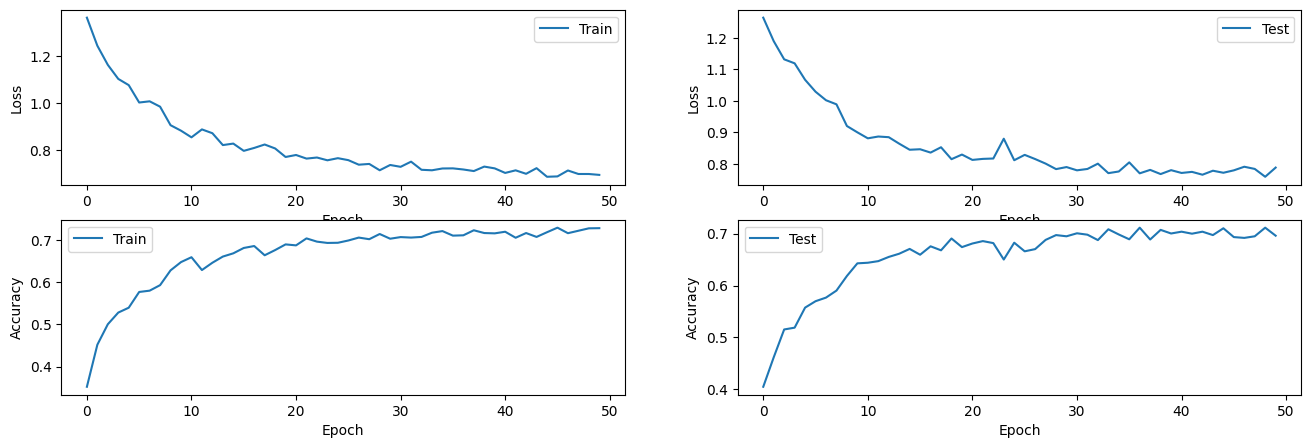

In [18]:
visualize(train_losses, test_losses, train_acc, test_acc)

# 5. Thêm một số cải tiến

## 5.1. Tích hợp thêm các cơ chế
1. **Spatial Attention**: Học trọng số giữa các kênh EEG.
2. **Residual Connections**: Hỗ trợ truyền thông tin giữa các lớp.
3. **Global Average Pooling (GAP)**: Thay thế Fully Connected để giảm số lượng tham số.

In [99]:
class SpatialAttention(nn.Module):
    """Spatial Attention Layer."""
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention_map = self.sigmoid(self.conv1(x))
        return x * attention_map

class ResidualBlock(nn.Module):
    """Residual Block with two convolutional layers."""
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, padding=padding, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = self.batchnorm2(self.conv2(x))
        if residual.shape != x.shape:
            residual = F.interpolate(residual, size=x.shape[2:])
        x += residual
        return F.relu(x)

class EEGNetElite(nn.Module):
    def __init__(self, num_classes, C=22, T=1875, F1=8, D=2, F2=16):
        super(EEGNetElite, self).__init__()
        
        # Block 1: Temporal Convolution + Spatial Attention
        self.conv1 = nn.Conv2d(1, F1, kernel_size=(1, 64), padding=(0, 32), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        self.depthwise_conv = nn.Conv2d(F1, F1 * D, kernel_size=(C, 1), groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.spatial_attention = SpatialAttention(F1 * D)
        self.elu1 = nn.ELU()
        self.pool1 = nn.AvgPool2d(kernel_size=(1, 4))
        self.dropout1 = nn.Dropout(0.5)

        # Block 2: Residual Convolutional Block
        self.residual_block = ResidualBlock(F1 * D, F2, kernel_size=(1, 16), padding=(0, 8))

        # Classification block
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(F2, num_classes)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.depthwise_conv(x)
        x = self.batchnorm2(x)
        x = self.spatial_attention(x)
        x = self.elu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = self.residual_block(x)

        # Classification
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

In [100]:
eeg_net_elite = EEGNetElite(num_classes=num_classes)
eeg_net_elite = nn.DataParallel(eeg_net_elite)

**Thực nghiệm mô hình**

In [101]:
lr = 0.003
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(eeg_net_elite.parameters(), lr=lr)

In [103]:
eeg_elite_wan_writer = wandb.init(
    project="motor imagery",
    name="EEG-Net-Elite",
    config={
        "learning_rate": 0.003,
        "batch_size": 16,
        "epochs": 50,
    }
)

In [104]:
save_path = '/kaggle/working/eeg_elite.pth'
train_losses, train_acc, test_losses, test_acc = train_model(eeg_net_elite, train_loader, test_loader, criterion, optimizer, save_path, device, epochs=50, wandb_writer=eeg_elite_wan_writer)

Training epoch [1/50]: 100%|██████████| 162/162 [00:02<00:00, 56.48batch/s]


	---> Loss: 1.3891
	---> Accuracy: 0.2492


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 91.09batch/s]


	---> Loss: 1.3868
	---> Accuracy: 0.2616
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.38      0.04      0.07       648
  Right Hand       0.29      0.12      0.17       648
        Foot       0.00      0.00      0.00       648
      Tongue       0.26      0.88      0.40       648

    accuracy                           0.26      2592
   macro avg       0.23      0.26      0.16      2592
weighted avg       0.23      0.26      0.16      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [2/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [2/50]: 100%|██████████| 162/162 [00:02<00:00, 61.98batch/s]


	---> Loss: 1.3804
	---> Accuracy: 0.2840


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 95.96batch/s]


	---> Loss: 1.3862
	---> Accuracy: 0.2924
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.32      0.04      0.08       648
  Right Hand       0.31      0.13      0.18       648
        Foot       0.30      0.21      0.25       648
      Tongue       0.29      0.78      0.42       648

    accuracy                           0.29      2592
   macro avg       0.30      0.29      0.23      2592
weighted avg       0.30      0.29      0.23      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [3/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [3/50]: 100%|██████████| 162/162 [00:02<00:00, 62.24batch/s]


	---> Loss: 1.3644
	---> Accuracy: 0.3218


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 94.47batch/s]


	---> Loss: 1.3629
	---> Accuracy: 0.3202
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.28      0.53      0.37       648
  Right Hand       0.38      0.10      0.15       648
        Foot       0.34      0.35      0.35       648
      Tongue       0.36      0.30      0.33       648

    accuracy                           0.32      2592
   macro avg       0.34      0.32      0.30      2592
weighted avg       0.34      0.32      0.30      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [4/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [4/50]: 100%|██████████| 162/162 [00:02<00:00, 60.68batch/s]


	---> Loss: 1.3525
	---> Accuracy: 0.3380


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 99.20batch/s] 


	---> Loss: 1.3662
	---> Accuracy: 0.3248
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.28      0.63      0.39       648
  Right Hand       0.32      0.27      0.29       648
        Foot       0.44      0.19      0.27       648
      Tongue       0.44      0.20      0.28       648

    accuracy                           0.32      2592
   macro avg       0.37      0.32      0.31      2592
weighted avg       0.37      0.32      0.31      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [5/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [5/50]: 100%|██████████| 162/162 [00:02<00:00, 61.42batch/s]


	---> Loss: 1.3357
	---> Accuracy: 0.3611


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 98.49batch/s] 


	---> Loss: 1.3473
	---> Accuracy: 0.3310
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.31      0.22      0.26       648
  Right Hand       0.34      0.06      0.10       648
        Foot       0.30      0.55      0.39       648
      Tongue       0.39      0.50      0.44       648

    accuracy                           0.33      2592
   macro avg       0.34      0.33      0.29      2592
weighted avg       0.34      0.33      0.29      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [6/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [6/50]: 100%|██████████| 162/162 [00:02<00:00, 63.27batch/s]


	---> Loss: 1.3208
	---> Accuracy: 0.3800


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.27batch/s] 


	---> Loss: 1.3501
	---> Accuracy: 0.3484
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.31      0.08      0.13       648
  Right Hand       0.30      0.58      0.40       648
        Foot       0.36      0.47      0.41       648
      Tongue       0.51      0.25      0.34       648

    accuracy                           0.35      2592
   macro avg       0.37      0.35      0.32      2592
weighted avg       0.37      0.35      0.32      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [7/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [7/50]: 100%|██████████| 162/162 [00:02<00:00, 61.83batch/s]


	---> Loss: 1.3136
	---> Accuracy: 0.3796


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.62batch/s] 


	---> Loss: 1.3628
	---> Accuracy: 0.3283
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.32      0.27      0.29       648
  Right Hand       0.40      0.13      0.19       648
        Foot       0.42      0.14      0.21       648
      Tongue       0.31      0.77      0.44       648

    accuracy                           0.33      2592
   macro avg       0.36      0.33      0.29      2592
weighted avg       0.36      0.33      0.29      2592



Training epoch [8/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [8/50]: 100%|██████████| 162/162 [00:02<00:00, 62.16batch/s]


	---> Loss: 1.2980
	---> Accuracy: 0.3974


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 88.63batch/s]


	---> Loss: 1.4674
	---> Accuracy: 0.2936
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.45      0.06      0.10       648
  Right Hand       0.38      0.10      0.16       648
        Foot       0.43      0.09      0.15       648
      Tongue       0.27      0.92      0.42       648

    accuracy                           0.29      2592
   macro avg       0.38      0.29      0.21      2592
weighted avg       0.38      0.29      0.21      2592



Training epoch [9/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [9/50]: 100%|██████████| 162/162 [00:02<00:00, 60.92batch/s]


	---> Loss: 1.2886
	---> Accuracy: 0.3989


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 94.60batch/s]


	---> Loss: 1.3763
	---> Accuracy: 0.3144
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.39      0.10      0.16       648
  Right Hand       0.33      0.09      0.15       648
        Foot       0.39      0.23      0.29       648
      Tongue       0.29      0.83      0.43       648

    accuracy                           0.31      2592
   macro avg       0.35      0.31      0.26      2592
weighted avg       0.35      0.31      0.26      2592



Training epoch [10/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [10/50]: 100%|██████████| 162/162 [00:02<00:00, 62.76batch/s]


	---> Loss: 1.2893
	---> Accuracy: 0.4078


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.34batch/s]


	---> Loss: 1.3095
	---> Accuracy: 0.3962
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.45      0.08      0.14       648
  Right Hand       0.35      0.57      0.44       648
        Foot       0.40      0.42      0.41       648
      Tongue       0.44      0.51      0.47       648

    accuracy                           0.40      2592
   macro avg       0.41      0.40      0.37      2592
weighted avg       0.41      0.40      0.37      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [11/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [11/50]: 100%|██████████| 162/162 [00:02<00:00, 61.89batch/s]


	---> Loss: 1.2696
	---> Accuracy: 0.4178


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 94.16batch/s]


	---> Loss: 1.3076
	---> Accuracy: 0.3885
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.34      0.28      0.31       648
  Right Hand       0.42      0.24      0.30       648
        Foot       0.36      0.54      0.43       648
      Tongue       0.44      0.50      0.47       648

    accuracy                           0.39      2592
   macro avg       0.39      0.39      0.38      2592
weighted avg       0.39      0.39      0.38      2592



Training epoch [12/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [12/50]: 100%|██████████| 162/162 [00:02<00:00, 60.94batch/s]


	---> Loss: 1.2549
	---> Accuracy: 0.4236


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.56batch/s]


	---> Loss: 1.3135
	---> Accuracy: 0.3839
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.37      0.24      0.29       648
  Right Hand       0.42      0.24      0.30       648
        Foot       0.39      0.39      0.39       648
      Tongue       0.38      0.67      0.48       648

    accuracy                           0.38      2592
   macro avg       0.39      0.38      0.37      2592
weighted avg       0.39      0.38      0.37      2592



Training epoch [13/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [13/50]: 100%|██████████| 162/162 [00:02<00:00, 62.05batch/s]


	---> Loss: 1.2606
	---> Accuracy: 0.4113


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.50batch/s]


	---> Loss: 1.2915
	---> Accuracy: 0.4016
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.37      0.26      0.30       648
  Right Hand       0.41      0.29      0.34       648
        Foot       0.37      0.64      0.47       648
      Tongue       0.48      0.42      0.44       648

    accuracy                           0.40      2592
   macro avg       0.41      0.40      0.39      2592
weighted avg       0.41      0.40      0.39      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [14/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [14/50]: 100%|██████████| 162/162 [00:02<00:00, 62.06batch/s]


	---> Loss: 1.2506
	---> Accuracy: 0.4240


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 95.25batch/s]


	---> Loss: 1.3072
	---> Accuracy: 0.4020
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.37      0.24      0.29       648
  Right Hand       0.41      0.30      0.34       648
        Foot       0.46      0.39      0.42       648
      Tongue       0.38      0.68      0.49       648

    accuracy                           0.40      2592
   macro avg       0.41      0.40      0.39      2592
weighted avg       0.41      0.40      0.39      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [15/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [15/50]: 100%|██████████| 162/162 [00:02<00:00, 62.46batch/s]


	---> Loss: 1.2367
	---> Accuracy: 0.4456


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 99.02batch/s]


	---> Loss: 1.3019
	---> Accuracy: 0.3981
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.36      0.32      0.34       648
  Right Hand       0.43      0.24      0.31       648
        Foot       0.36      0.62      0.45       648
      Tongue       0.50      0.41      0.45       648

    accuracy                           0.40      2592
   macro avg       0.41      0.40      0.39      2592
weighted avg       0.41      0.40      0.39      2592



Training epoch [16/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [16/50]: 100%|██████████| 162/162 [00:02<00:00, 56.71batch/s]


	---> Loss: 1.2328
	---> Accuracy: 0.4452


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.18batch/s] 


	---> Loss: 1.2893
	---> Accuracy: 0.4120
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.38      0.29      0.33       648
  Right Hand       0.46      0.24      0.31       648
        Foot       0.42      0.52      0.46       648
      Tongue       0.41      0.61      0.49       648

    accuracy                           0.41      2592
   macro avg       0.42      0.41      0.40      2592
weighted avg       0.42      0.41      0.40      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [17/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [17/50]: 100%|██████████| 162/162 [00:02<00:00, 61.69batch/s]


	---> Loss: 1.2295
	---> Accuracy: 0.4452


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 99.94batch/s] 


	---> Loss: 1.2797
	---> Accuracy: 0.4163
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.38      0.19      0.25       648
  Right Hand       0.40      0.46      0.43       648
        Foot       0.42      0.48      0.45       648
      Tongue       0.44      0.54      0.48       648

    accuracy                           0.42      2592
   macro avg       0.41      0.42      0.40      2592
weighted avg       0.41      0.42      0.40      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [18/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [18/50]: 100%|██████████| 162/162 [00:02<00:00, 64.28batch/s]


	---> Loss: 1.2225
	---> Accuracy: 0.4525


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 99.56batch/s]


	---> Loss: 1.2802
	---> Accuracy: 0.4097
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.37      0.31      0.34       648
  Right Hand       0.46      0.22      0.30       648
        Foot       0.37      0.65      0.48       648
      Tongue       0.48      0.46      0.47       648

    accuracy                           0.41      2592
   macro avg       0.42      0.41      0.40      2592
weighted avg       0.42      0.41      0.40      2592



Training epoch [19/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [19/50]: 100%|██████████| 162/162 [00:02<00:00, 61.76batch/s]


	---> Loss: 1.2165
	---> Accuracy: 0.4587


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.52batch/s] 


	---> Loss: 1.2832
	---> Accuracy: 0.4205
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.38      0.41      0.40       648
  Right Hand       0.45      0.29      0.35       648
        Foot       0.51      0.38      0.43       648
      Tongue       0.40      0.61      0.48       648

    accuracy                           0.42      2592
   macro avg       0.43      0.42      0.41      2592
weighted avg       0.43      0.42      0.41      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [20/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [20/50]: 100%|██████████| 162/162 [00:02<00:00, 62.11batch/s]


	---> Loss: 1.2033
	---> Accuracy: 0.4583


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.71batch/s]


	---> Loss: 1.2457
	---> Accuracy: 0.4448
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.53      0.14      0.22       648
  Right Hand       0.42      0.58      0.49       648
        Foot       0.43      0.52      0.47       648
      Tongue       0.47      0.54      0.50       648

    accuracy                           0.44      2592
   macro avg       0.46      0.44      0.42      2592
weighted avg       0.46      0.44      0.42      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [21/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [21/50]: 100%|██████████| 162/162 [00:02<00:00, 60.91batch/s]


	---> Loss: 1.1999
	---> Accuracy: 0.4676


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 99.82batch/s] 


	---> Loss: 1.2908
	---> Accuracy: 0.4008
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.44      0.21      0.29       648
  Right Hand       0.47      0.21      0.29       648
        Foot       0.48      0.38      0.42       648
      Tongue       0.35      0.81      0.49       648

    accuracy                           0.40      2592
   macro avg       0.44      0.40      0.37      2592
weighted avg       0.44      0.40      0.37      2592



Training epoch [22/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [22/50]: 100%|██████████| 162/162 [00:02<00:00, 62.61batch/s]


	---> Loss: 1.1960
	---> Accuracy: 0.4653


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.45batch/s] 


	---> Loss: 1.2567
	---> Accuracy: 0.4329
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.36      0.42      0.39       648
  Right Hand       0.46      0.39      0.42       648
        Foot       0.50      0.41      0.45       648
      Tongue       0.44      0.51      0.48       648

    accuracy                           0.43      2592
   macro avg       0.44      0.43      0.43      2592
weighted avg       0.44      0.43      0.43      2592



Training epoch [23/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [23/50]: 100%|██████████| 162/162 [00:02<00:00, 61.77batch/s]


	---> Loss: 1.1776
	---> Accuracy: 0.4668


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 86.40batch/s]


	---> Loss: 1.2862
	---> Accuracy: 0.4306
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.43      0.29      0.35       648
  Right Hand       0.44      0.42      0.43       648
        Foot       0.54      0.29      0.38       648
      Tongue       0.39      0.72      0.51       648

    accuracy                           0.43      2592
   macro avg       0.45      0.43      0.42      2592
weighted avg       0.45      0.43      0.42      2592



Training epoch [24/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [24/50]: 100%|██████████| 162/162 [00:02<00:00, 63.26batch/s]


	---> Loss: 1.1701
	---> Accuracy: 0.4796


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 95.44batch/s] 


	---> Loss: 1.2931
	---> Accuracy: 0.4317
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.40      0.27      0.32       648
  Right Hand       0.57      0.31      0.40       648
        Foot       0.47      0.44      0.45       648
      Tongue       0.38      0.71      0.50       648

    accuracy                           0.43      2592
   macro avg       0.46      0.43      0.42      2592
weighted avg       0.46      0.43      0.42      2592



Training epoch [25/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [25/50]: 100%|██████████| 162/162 [00:02<00:00, 63.17batch/s]


	---> Loss: 1.1637
	---> Accuracy: 0.4938


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 98.55batch/s] 


	---> Loss: 1.3167
	---> Accuracy: 0.4367
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.41      0.32      0.36       648
  Right Hand       0.40      0.61      0.48       648
        Foot       0.48      0.42      0.44       648
      Tongue       0.48      0.40      0.44       648

    accuracy                           0.44      2592
   macro avg       0.44      0.44      0.43      2592
weighted avg       0.44      0.44      0.43      2592



Training epoch [26/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [26/50]: 100%|██████████| 162/162 [00:02<00:00, 62.27batch/s]


	---> Loss: 1.1639
	---> Accuracy: 0.4726


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 98.25batch/s]


	---> Loss: 1.2211
	---> Accuracy: 0.4568
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.43      0.35      0.39       648
  Right Hand       0.41      0.63      0.50       648
        Foot       0.52      0.37      0.43       648
      Tongue       0.51      0.47      0.49       648

    accuracy                           0.46      2592
   macro avg       0.47      0.46      0.45      2592
weighted avg       0.47      0.46      0.45      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [27/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [27/50]: 100%|██████████| 162/162 [00:02<00:00, 63.19batch/s]


	---> Loss: 1.1526
	---> Accuracy: 0.4826


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.11batch/s]


	---> Loss: 1.2370
	---> Accuracy: 0.4340
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.43      0.23      0.30       648
  Right Hand       0.52      0.28      0.37       648
        Foot       0.40      0.63      0.49       648
      Tongue       0.44      0.59      0.50       648

    accuracy                           0.43      2592
   macro avg       0.45      0.43      0.42      2592
weighted avg       0.45      0.43      0.42      2592



Training epoch [28/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [28/50]: 100%|██████████| 162/162 [00:02<00:00, 62.24batch/s]


	---> Loss: 1.1556
	---> Accuracy: 0.5004


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.82batch/s] 


	---> Loss: 1.2652
	---> Accuracy: 0.4456
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.49      0.23      0.32       648
  Right Hand       0.40      0.68      0.50       648
        Foot       0.47      0.48      0.48       648
      Tongue       0.48      0.39      0.43       648

    accuracy                           0.45      2592
   macro avg       0.46      0.45      0.43      2592
weighted avg       0.46      0.45      0.43      2592



Training epoch [29/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [29/50]: 100%|██████████| 162/162 [00:02<00:00, 63.50batch/s]


	---> Loss: 1.1524
	---> Accuracy: 0.4938


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.81batch/s]


	---> Loss: 1.2371
	---> Accuracy: 0.4541
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.45      0.35      0.39       648
  Right Hand       0.50      0.36      0.42       648
        Foot       0.42      0.60      0.50       648
      Tongue       0.47      0.51      0.49       648

    accuracy                           0.45      2592
   macro avg       0.46      0.45      0.45      2592
weighted avg       0.46      0.45      0.45      2592



Training epoch [30/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [30/50]: 100%|██████████| 162/162 [00:02<00:00, 64.38batch/s]


	---> Loss: 1.1405
	---> Accuracy: 0.4942


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 92.57batch/s]


	---> Loss: 1.2195
	---> Accuracy: 0.4657
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.49      0.28      0.36       648
  Right Hand       0.46      0.50      0.48       648
        Foot       0.45      0.54      0.49       648
      Tongue       0.47      0.53      0.50       648

    accuracy                           0.47      2592
   macro avg       0.47      0.47      0.46      2592
weighted avg       0.47      0.47      0.46      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [31/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [31/50]: 100%|██████████| 162/162 [00:02<00:00, 58.57batch/s]


	---> Loss: 1.1183
	---> Accuracy: 0.5096


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 99.45batch/s] 


	---> Loss: 1.2485
	---> Accuracy: 0.4514
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.42      0.37      0.39       648
  Right Hand       0.61      0.31      0.41       648
        Foot       0.42      0.62      0.50       648
      Tongue       0.44      0.51      0.47       648

    accuracy                           0.45      2592
   macro avg       0.47      0.45      0.44      2592
weighted avg       0.47      0.45      0.44      2592



Training epoch [32/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [32/50]: 100%|██████████| 162/162 [00:02<00:00, 63.70batch/s]


	---> Loss: 1.1372
	---> Accuracy: 0.5012


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 100.40batch/s]


	---> Loss: 1.2053
	---> Accuracy: 0.4684
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.52      0.28      0.37       648
  Right Hand       0.47      0.54      0.50       648
        Foot       0.42      0.60      0.50       648
      Tongue       0.51      0.45      0.48       648

    accuracy                           0.47      2592
   macro avg       0.48      0.47      0.46      2592
weighted avg       0.48      0.47      0.46      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [33/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [33/50]: 100%|██████████| 162/162 [00:02<00:00, 60.96batch/s]


	---> Loss: 1.1102
	---> Accuracy: 0.5193


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.98batch/s] 


	---> Loss: 1.2577
	---> Accuracy: 0.4533
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.44      0.43      0.43       648
  Right Hand       0.67      0.25      0.36       648
        Foot       0.41      0.61      0.49       648
      Tongue       0.45      0.53      0.48       648

    accuracy                           0.45      2592
   macro avg       0.49      0.45      0.44      2592
weighted avg       0.49      0.45      0.44      2592



Training epoch [34/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [34/50]: 100%|██████████| 162/162 [00:02<00:00, 63.51batch/s]


	---> Loss: 1.0962
	---> Accuracy: 0.5204


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 98.56batch/s]


	---> Loss: 1.2012
	---> Accuracy: 0.4823
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.44      0.50      0.47       648
  Right Hand       0.48      0.51      0.49       648
        Foot       0.45      0.55      0.50       648
      Tongue       0.63      0.38      0.47       648

    accuracy                           0.48      2592
   macro avg       0.50      0.48      0.48      2592
weighted avg       0.50      0.48      0.48      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [35/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [35/50]: 100%|██████████| 162/162 [00:02<00:00, 61.01batch/s]


	---> Loss: 1.1258
	---> Accuracy: 0.5035


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.94batch/s] 


	---> Loss: 1.1842
	---> Accuracy: 0.4819
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.54      0.30      0.39       648
  Right Hand       0.49      0.52      0.51       648
        Foot       0.49      0.49      0.49       648
      Tongue       0.44      0.61      0.51       648

    accuracy                           0.48      2592
   macro avg       0.49      0.48      0.47      2592
weighted avg       0.49      0.48      0.47      2592



Training epoch [36/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [36/50]: 100%|██████████| 162/162 [00:02<00:00, 64.02batch/s]


	---> Loss: 1.0888
	---> Accuracy: 0.5251


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.64batch/s]


	---> Loss: 1.1782
	---> Accuracy: 0.4838
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.47      0.39      0.43       648
  Right Hand       0.48      0.48      0.48       648
        Foot       0.47      0.51      0.49       648
      Tongue       0.50      0.55      0.53       648

    accuracy                           0.48      2592
   macro avg       0.48      0.48      0.48      2592
weighted avg       0.48      0.48      0.48      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [37/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [37/50]: 100%|██████████| 162/162 [00:02<00:00, 61.23batch/s]


	---> Loss: 1.1082
	---> Accuracy: 0.5046


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.19batch/s] 


	---> Loss: 1.1735
	---> Accuracy: 0.4884
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.50      0.38      0.43       648
  Right Hand       0.50      0.50      0.50       648
        Foot       0.48      0.46      0.47       648
      Tongue       0.48      0.61      0.54       648

    accuracy                           0.49      2592
   macro avg       0.49      0.49      0.48      2592
weighted avg       0.49      0.49      0.48      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [38/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [38/50]: 100%|██████████| 162/162 [00:02<00:00, 56.71batch/s]


	---> Loss: 1.0933
	---> Accuracy: 0.5189


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 91.82batch/s]


	---> Loss: 1.2104
	---> Accuracy: 0.4684
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.47      0.41      0.44       648
  Right Hand       0.49      0.39      0.44       648
        Foot       0.47      0.51      0.49       648
      Tongue       0.45      0.56      0.50       648

    accuracy                           0.47      2592
   macro avg       0.47      0.47      0.47      2592
weighted avg       0.47      0.47      0.47      2592



Training epoch [39/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [39/50]: 100%|██████████| 162/162 [00:02<00:00, 62.61batch/s]


	---> Loss: 1.0839
	---> Accuracy: 0.5285


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.88batch/s]


	---> Loss: 1.2844
	---> Accuracy: 0.4456
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.57      0.22      0.32       648
  Right Hand       0.58      0.30      0.39       648
        Foot       0.41      0.64      0.50       648
      Tongue       0.40      0.62      0.49       648

    accuracy                           0.45      2592
   macro avg       0.49      0.45      0.43      2592
weighted avg       0.49      0.45      0.43      2592



Training epoch [40/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [40/50]: 100%|██████████| 162/162 [00:02<00:00, 60.36batch/s]


	---> Loss: 1.0711
	---> Accuracy: 0.5347


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.91batch/s]


	---> Loss: 1.2156
	---> Accuracy: 0.4757
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.50      0.38      0.43       648
  Right Hand       0.61      0.35      0.44       648
        Foot       0.40      0.71      0.51       648
      Tongue       0.52      0.47      0.49       648

    accuracy                           0.48      2592
   macro avg       0.51      0.48      0.47      2592
weighted avg       0.51      0.48      0.47      2592



Training epoch [41/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [41/50]: 100%|██████████| 162/162 [00:02<00:00, 63.39batch/s]


	---> Loss: 1.0815
	---> Accuracy: 0.5285


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 98.96batch/s] 


	---> Loss: 1.2253
	---> Accuracy: 0.4637
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.56      0.27      0.36       648
  Right Hand       0.51      0.43      0.47       648
        Foot       0.38      0.72      0.50       648
      Tongue       0.56      0.43      0.49       648

    accuracy                           0.46      2592
   macro avg       0.50      0.46      0.45      2592
weighted avg       0.50      0.46      0.45      2592



Training epoch [42/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [42/50]: 100%|██████████| 162/162 [00:02<00:00, 61.76batch/s]


	---> Loss: 1.0694
	---> Accuracy: 0.5482


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 99.03batch/s] 


	---> Loss: 1.1570
	---> Accuracy: 0.4973
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.53      0.46      0.49       648
  Right Hand       0.49      0.48      0.48       648
        Foot       0.45      0.61      0.52       648
      Tongue       0.55      0.44      0.49       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [43/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [43/50]: 100%|██████████| 162/162 [00:02<00:00, 64.06batch/s]


	---> Loss: 1.0771
	---> Accuracy: 0.5471


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 100.36batch/s]


	---> Loss: 1.2235
	---> Accuracy: 0.4780
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.53      0.36      0.43       648
  Right Hand       0.46      0.54      0.50       648
        Foot       0.48      0.45      0.47       648
      Tongue       0.46      0.56      0.50       648

    accuracy                           0.48      2592
   macro avg       0.48      0.48      0.47      2592
weighted avg       0.48      0.48      0.47      2592



Training epoch [44/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [44/50]: 100%|██████████| 162/162 [00:02<00:00, 65.10batch/s]


	---> Loss: 1.0729
	---> Accuracy: 0.5312


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.94batch/s] 


	---> Loss: 1.2075
	---> Accuracy: 0.4722
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.56      0.30      0.39       648
  Right Hand       0.44      0.61      0.51       648
        Foot       0.46      0.52      0.49       648
      Tongue       0.48      0.47      0.47       648

    accuracy                           0.47      2592
   macro avg       0.49      0.47      0.47      2592
weighted avg       0.49      0.47      0.47      2592



Training epoch [45/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [45/50]: 100%|██████████| 162/162 [00:02<00:00, 62.61batch/s]


	---> Loss: 1.0837
	---> Accuracy: 0.5316


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 88.03batch/s]


	---> Loss: 1.3333
	---> Accuracy: 0.4333
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.60      0.15      0.24       648
  Right Hand       0.54      0.44      0.48       648
        Foot       0.54      0.31      0.39       648
      Tongue       0.35      0.84      0.50       648

    accuracy                           0.43      2592
   macro avg       0.51      0.43      0.40      2592
weighted avg       0.51      0.43      0.40      2592



Training epoch [46/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [46/50]: 100%|██████████| 162/162 [00:02<00:00, 60.82batch/s]


	---> Loss: 1.0734
	---> Accuracy: 0.5390


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 98.32batch/s]


	---> Loss: 1.1888
	---> Accuracy: 0.4904
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.48      0.58      0.52       648
  Right Hand       0.48      0.53      0.51       648
        Foot       0.49      0.41      0.45       648
      Tongue       0.53      0.44      0.48       648

    accuracy                           0.49      2592
   macro avg       0.49      0.49      0.49      2592
weighted avg       0.49      0.49      0.49      2592



Training epoch [47/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [47/50]: 100%|██████████| 162/162 [00:02<00:00, 62.62batch/s]


	---> Loss: 1.0694
	---> Accuracy: 0.5374


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 99.94batch/s]


	---> Loss: 1.1436
	---> Accuracy: 0.4969
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.50      0.54      0.52       648
  Right Hand       0.52      0.46      0.49       648
        Foot       0.44      0.58      0.50       648
      Tongue       0.57      0.41      0.47       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592



Training epoch [48/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [48/50]: 100%|██████████| 162/162 [00:02<00:00, 62.04batch/s]


	---> Loss: 1.0707
	---> Accuracy: 0.5355


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 98.58batch/s] 


	---> Loss: 1.2378
	---> Accuracy: 0.4707
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.66      0.16      0.26       648
  Right Hand       0.49      0.56      0.52       648
        Foot       0.43      0.56      0.49       648
      Tongue       0.45      0.61      0.52       648

    accuracy                           0.47      2592
   macro avg       0.51      0.47      0.45      2592
weighted avg       0.51      0.47      0.45      2592



Training epoch [49/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [49/50]: 100%|██████████| 162/162 [00:02<00:00, 62.27batch/s]


	---> Loss: 1.0688
	---> Accuracy: 0.5444


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 99.01batch/s] 


	---> Loss: 1.1575
	---> Accuracy: 0.5096
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.48      0.60      0.53       648
  Right Hand       0.48      0.56      0.52       648
        Foot       0.52      0.44      0.48       648
      Tongue       0.59      0.44      0.50       648

    accuracy                           0.51      2592
   macro avg       0.52      0.51      0.51      2592
weighted avg       0.52      0.51      0.51      2592

Model is saved to  /kaggle/working/eeg_elite.pth


Training epoch [50/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [50/50]: 100%|██████████| 162/162 [00:02<00:00, 63.83batch/s]


	---> Loss: 1.0431
	---> Accuracy: 0.5552


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 100.07batch/s]

	---> Loss: 1.1758
	---> Accuracy: 0.4892
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.54      0.39      0.45       648
  Right Hand       0.51      0.49      0.50       648
        Foot       0.43      0.64      0.51       648
      Tongue       0.54      0.43      0.48       648

    accuracy                           0.49      2592
   macro avg       0.50      0.49      0.49      2592
weighted avg       0.50      0.49      0.49      2592



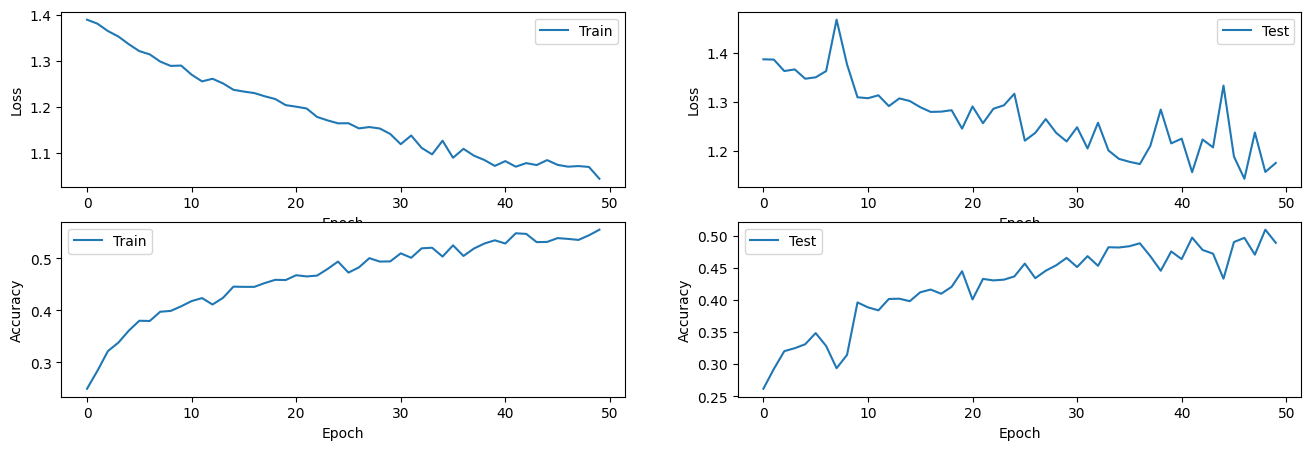

In [105]:
visualize(train_losses, test_losses, train_acc, test_acc)

## 5.2. Tích hợp thêm các cơ chế khác
1. **Spatial Attention**: Học trọng số giữa các kênh EEG.
2. **Residual Connections**: Hỗ trợ truyền thông tin giữa các lớp.
3. **Global Average Pooling (GAP)**: Thay thế Fully Connected để giảm số lượng tham số.
4. **DropBlock**: để thay thế Dropout.
5. **Layer Normalization**: thay thế Batch Normalization.
6. **Multi-Head Attention**: để học mối quan hệ không gian-thời gian phức tạp.

In [ ]:
class DropBlock2D(nn.Module):
    """DropBlock layer."""
    def __init__(self, block_size, drop_prob):
        super(DropBlock2D, self).__init__()
        self.block_size = block_size
        self.drop_prob = drop_prob

    def forward(self, x):
        if not self.training or self.drop_prob == 0:
            return x
        gamma = self.drop_prob / (self.block_size ** 2)
        mask = (torch.rand_like(x) < gamma).float()
        mask = F.max_pool2d(mask, self.block_size, stride=1, padding=self.block_size // 2)
        mask = 1 - mask
        return x * mask

class EEGNetHero(nn.Module):
    def __init__(self, num_classes, C=22, T=1875, F1=8, D=2, F2=16, num_heads=4):
        super(EEGNetHero, self).__init__()
        
        # Block 1: Temporal Convolution + Spatial Attention
        self.conv1 = nn.Conv2d(1, F1, kernel_size=(1, 64), padding=(0, 32), bias=False)
        self.layernorm1 = nn.LayerNorm([F1, C, T])
        self.depthwise_conv = nn.Conv2d(F1, F1 * D, kernel_size=(C, 1), groups=F1, bias=False)
        self.layernorm2 = nn.LayerNorm([F1 * D, 1, T])
        self.spatial_attention = SpatialAttention(F1 * D)
        self.elu1 = nn.ELU()
        self.pool1 = nn.AvgPool2d(kernel_size=(1, 4))
        self.dropblock1 = DropBlock2D(block_size=3, drop_prob=0.5)

        # Block 2: Multi-Head Attention
        self.multihead_attn = nn.MultiheadAttention(embed_dim=F1 * D, num_heads=num_heads)

        # Block 3: Separable Convolution
        self.separable_conv = nn.Conv2d(F1 * D, F2, kernel_size=(1, 16), padding=(0, 8), bias=False)
        self.layernorm3 = nn.LayerNorm([F2, 1, T // 4])
        self.elu2 = nn.ELU()
        self.pool2 = nn.AvgPool2d(kernel_size=(1, 8))
        self.dropblock2 = DropBlock2D(block_size=3, drop_prob=0.5)

        # Classification block
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(F2, num_classes)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.layernorm1(x)
        x = self.depthwise_conv(x)
        x = self.layernorm2(x)
        x = self.spatial_attention(x)
        x = self.elu1(x)
        x = self.pool1(x)
        x = self.dropblock1(x)

        # Block 2
        x = x.flatten(start_dim=2).permute(2, 0, 1)  # (batch, channel, time) -> (time, batch, channel)
        x, _ = self.multihead_attn(x, x, x)
        x = x.permute(1, 2, 0).view(x.size(1), -1, T // 4)

        # Block 3
        x = self.separable_conv(x)
        x = self.layernorm3(x)
        x = self.elu2(x)
        x = self.pool2(x)
        x = self.dropblock2(x)

        # Classification
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x


**Thử nghiệm mô hình**

In [117]:
eeg_net_hero = EEGNetHero(num_classes=num_classes)
eeg_net_hero = nn.DataParallel(eeg_net_hero)

In [118]:
lr = 0.003
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(eeg_net_hero.parameters(), lr=lr)

In [ ]:
eeg_hero_wan_writer = wandb.init(
    project="motor imagery",
    name="EEG-Net-Hero",
    config={
        "learning_rate": 0.003,
        "batch_size": 16,
        "epochs": 50,
    }
)

In [125]:
save_path = '/kaggle/working/eeg_hero.pth'
train_losses, train_acc, test_losses, test_acc = train_model(eeg_net_elite, train_loader, test_loader, criterion, optimizer, save_path, device, epochs=50)

Training epoch [1/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [1/50]: 100%|██████████| 162/162 [00:02<00:00, 58.55batch/s]


	---> Loss: 1.0210
	---> Accuracy: 0.5818


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 100.23batch/s]


	---> Loss: 1.1618
	---> Accuracy: 0.4946
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.55      0.38      0.45       648
  Right Hand       0.48      0.52      0.50       648
        Foot       0.45      0.58      0.51       648
      Tongue       0.53      0.50      0.52       648

    accuracy                           0.49      2592
   macro avg       0.50      0.49      0.49      2592
weighted avg       0.50      0.49      0.49      2592

Model is saved to  /kaggle/working/eeg_hero.pth


Training epoch [2/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [2/50]: 100%|██████████| 162/162 [00:02<00:00, 60.70batch/s]


	---> Loss: 1.0043
	---> Accuracy: 0.5833


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 94.50batch/s]


	---> Loss: 1.1610
	---> Accuracy: 0.4988
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.56      0.38      0.45       648
  Right Hand       0.48      0.52      0.50       648
        Foot       0.45      0.60      0.52       648
      Tongue       0.54      0.49      0.52       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592

Model is saved to  /kaggle/working/eeg_hero.pth


Training epoch [3/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [3/50]: 100%|██████████| 162/162 [00:02<00:00, 62.09batch/s]


	---> Loss: 1.0165
	---> Accuracy: 0.5748


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 99.63batch/s] 


	---> Loss: 1.1628
	---> Accuracy: 0.4973
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.54      0.39      0.45       648
  Right Hand       0.51      0.48      0.49       648
        Foot       0.44      0.61      0.51       648
      Tongue       0.53      0.52      0.53       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592



Training epoch [4/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [4/50]: 100%|██████████| 162/162 [00:02<00:00, 62.43batch/s]


	---> Loss: 1.0214
	---> Accuracy: 0.5741


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 98.45batch/s] 


	---> Loss: 1.1653
	---> Accuracy: 0.4942
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.54      0.39      0.45       648
  Right Hand       0.48      0.52      0.50       648
        Foot       0.45      0.59      0.51       648
      Tongue       0.54      0.48      0.51       648

    accuracy                           0.49      2592
   macro avg       0.50      0.49      0.49      2592
weighted avg       0.50      0.49      0.49      2592



Training epoch [5/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [5/50]: 100%|██████████| 162/162 [00:02<00:00, 61.48batch/s]


	---> Loss: 1.0117
	---> Accuracy: 0.5733


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 95.03batch/s]


	---> Loss: 1.1561
	---> Accuracy: 0.5004
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.53      0.43      0.47       648
  Right Hand       0.46      0.59      0.52       648
        Foot       0.48      0.50      0.49       648
      Tongue       0.56      0.49      0.52       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592

Model is saved to  /kaggle/working/eeg_hero.pth


Training epoch [6/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [6/50]: 100%|██████████| 162/162 [00:02<00:00, 62.06batch/s]


	---> Loss: 1.0101
	---> Accuracy: 0.5791


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.01batch/s]


	---> Loss: 1.1506
	---> Accuracy: 0.5004
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.51      0.46      0.48       648
  Right Hand       0.49      0.50      0.50       648
        Foot       0.47      0.53      0.50       648
      Tongue       0.54      0.51      0.52       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [7/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [7/50]: 100%|██████████| 162/162 [00:02<00:00, 62.46batch/s]


	---> Loss: 0.9908
	---> Accuracy: 0.5880


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.57batch/s]


	---> Loss: 1.1500
	---> Accuracy: 0.4969
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.54      0.41      0.46       648
  Right Hand       0.48      0.53      0.50       648
        Foot       0.46      0.55      0.50       648
      Tongue       0.54      0.50      0.52       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [8/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [8/50]: 100%|██████████| 162/162 [00:02<00:00, 58.26batch/s]


	---> Loss: 1.0181
	---> Accuracy: 0.5656


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 95.32batch/s]


	---> Loss: 1.1517
	---> Accuracy: 0.5042
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.53      0.43      0.48       648
  Right Hand       0.47      0.55      0.51       648
        Foot       0.48      0.52      0.49       648
      Tongue       0.55      0.52      0.53       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592

Model is saved to  /kaggle/working/eeg_hero.pth


Training epoch [9/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [9/50]: 100%|██████████| 162/162 [00:02<00:00, 63.19batch/s]


	---> Loss: 1.0155
	---> Accuracy: 0.5760


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.49batch/s]


	---> Loss: 1.1495
	---> Accuracy: 0.5039
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.51      0.47      0.49       648
  Right Hand       0.52      0.47      0.49       648
        Foot       0.47      0.54      0.50       648
      Tongue       0.53      0.54      0.53       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592



Training epoch [10/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [10/50]: 100%|██████████| 162/162 [00:02<00:00, 62.39batch/s]


	---> Loss: 1.0115
	---> Accuracy: 0.5822


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 98.26batch/s] 


	---> Loss: 1.1675
	---> Accuracy: 0.4973
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.55      0.37      0.44       648
  Right Hand       0.49      0.51      0.50       648
        Foot       0.44      0.60      0.51       648
      Tongue       0.55      0.50      0.52       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.49      2592
weighted avg       0.51      0.50      0.49      2592



Training epoch [11/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [11/50]: 100%|██████████| 162/162 [00:02<00:00, 60.99batch/s]


	---> Loss: 1.0131
	---> Accuracy: 0.5714


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.55batch/s]


	---> Loss: 1.1556
	---> Accuracy: 0.5046
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.54      0.41      0.47       648
  Right Hand       0.50      0.50      0.50       648
        Foot       0.46      0.56      0.51       648
      Tongue       0.53      0.54      0.54       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592

Model is saved to  /kaggle/working/eeg_hero.pth


Training epoch [12/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [12/50]: 100%|██████████| 162/162 [00:02<00:00, 60.52batch/s]


	---> Loss: 1.0090
	---> Accuracy: 0.5826


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.17batch/s]


	---> Loss: 1.1515
	---> Accuracy: 0.4977
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.52      0.43      0.47       648
  Right Hand       0.48      0.52      0.50       648
        Foot       0.47      0.52      0.49       648
      Tongue       0.53      0.52      0.53       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [13/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [13/50]: 100%|██████████| 162/162 [00:02<00:00, 62.54batch/s]


	---> Loss: 1.0145
	---> Accuracy: 0.5629


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.65batch/s]


	---> Loss: 1.1427
	---> Accuracy: 0.5039
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.52      0.45      0.48       648
  Right Hand       0.48      0.54      0.51       648
        Foot       0.51      0.45      0.48       648
      Tongue       0.52      0.57      0.54       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [14/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [14/50]: 100%|██████████| 162/162 [00:02<00:00, 61.43batch/s]


	---> Loss: 1.0115
	---> Accuracy: 0.5718


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 99.22batch/s]


	---> Loss: 1.1610
	---> Accuracy: 0.4973
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.52      0.42      0.46       648
  Right Hand       0.47      0.57      0.51       648
        Foot       0.46      0.54      0.50       648
      Tongue       0.57      0.46      0.51       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592



Training epoch [15/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [15/50]: 100%|██████████| 162/162 [00:02<00:00, 62.82batch/s]


	---> Loss: 1.0281
	---> Accuracy: 0.5633


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 85.44batch/s]


	---> Loss: 1.1807
	---> Accuracy: 0.4934
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.58      0.33      0.42       648
  Right Hand       0.47      0.56      0.51       648
        Foot       0.44      0.60      0.51       648
      Tongue       0.54      0.48      0.51       648

    accuracy                           0.49      2592
   macro avg       0.51      0.49      0.49      2592
weighted avg       0.51      0.49      0.49      2592



Training epoch [16/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [16/50]: 100%|██████████| 162/162 [00:02<00:00, 62.79batch/s]


	---> Loss: 1.0203
	---> Accuracy: 0.5540


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 95.49batch/s]


	---> Loss: 1.1473
	---> Accuracy: 0.5015
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.52      0.44      0.47       648
  Right Hand       0.49      0.53      0.51       648
        Foot       0.50      0.44      0.47       648
      Tongue       0.50      0.60      0.55       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [17/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [17/50]: 100%|██████████| 162/162 [00:02<00:00, 61.03batch/s]


	---> Loss: 1.0147
	---> Accuracy: 0.5660


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.88batch/s]


	---> Loss: 1.1563
	---> Accuracy: 0.5000
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.53      0.43      0.47       648
  Right Hand       0.48      0.52      0.50       648
        Foot       0.46      0.56      0.51       648
      Tongue       0.55      0.49      0.52       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592



Training epoch [18/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [18/50]: 100%|██████████| 162/162 [00:02<00:00, 62.53batch/s]


	---> Loss: 1.0221
	---> Accuracy: 0.5683


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.92batch/s] 


	---> Loss: 1.1552
	---> Accuracy: 0.4907
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.52      0.43      0.47       648
  Right Hand       0.47      0.54      0.50       648
        Foot       0.45      0.52      0.48       648
      Tongue       0.55      0.47      0.51       648

    accuracy                           0.49      2592
   macro avg       0.50      0.49      0.49      2592
weighted avg       0.50      0.49      0.49      2592



Training epoch [19/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [19/50]: 100%|██████████| 162/162 [00:02<00:00, 60.05batch/s]


	---> Loss: 1.0195
	---> Accuracy: 0.5660


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.92batch/s]


	---> Loss: 1.1502
	---> Accuracy: 0.5015
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.51      0.45      0.48       648
  Right Hand       0.51      0.48      0.50       648
        Foot       0.46      0.56      0.50       648
      Tongue       0.54      0.52      0.53       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [20/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [20/50]: 100%|██████████| 162/162 [00:02<00:00, 62.57batch/s]


	---> Loss: 1.0080
	---> Accuracy: 0.5610


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 94.08batch/s]


	---> Loss: 1.1527
	---> Accuracy: 0.5031
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.55      0.40      0.47       648
  Right Hand       0.46      0.57      0.51       648
        Foot       0.50      0.48      0.49       648
      Tongue       0.52      0.57      0.54       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592



Training epoch [21/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [21/50]: 100%|██████████| 162/162 [00:02<00:00, 62.01batch/s]


	---> Loss: 1.0273
	---> Accuracy: 0.5671


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.64batch/s]


	---> Loss: 1.1552
	---> Accuracy: 0.4985
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.54      0.40      0.46       648
  Right Hand       0.47      0.56      0.51       648
        Foot       0.47      0.52      0.49       648
      Tongue       0.54      0.51      0.53       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [22/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [22/50]: 100%|██████████| 162/162 [00:02<00:00, 60.87batch/s]


	---> Loss: 1.0101
	---> Accuracy: 0.5714


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 95.28batch/s]


	---> Loss: 1.1600
	---> Accuracy: 0.4981
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.54      0.41      0.46       648
  Right Hand       0.49      0.52      0.50       648
        Foot       0.45      0.57      0.51       648
      Tongue       0.54      0.50      0.52       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [23/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [23/50]: 100%|██████████| 162/162 [00:02<00:00, 56.51batch/s]


	---> Loss: 1.0143
	---> Accuracy: 0.5745


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 95.76batch/s]


	---> Loss: 1.1557
	---> Accuracy: 0.4958
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.54      0.40      0.46       648
  Right Hand       0.47      0.54      0.50       648
        Foot       0.46      0.52      0.49       648
      Tongue       0.54      0.52      0.53       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.49      2592
weighted avg       0.50      0.50      0.49      2592



Training epoch [24/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [24/50]: 100%|██████████| 162/162 [00:02<00:00, 62.69batch/s]


	---> Loss: 1.0046
	---> Accuracy: 0.5876


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.82batch/s] 


	---> Loss: 1.1627
	---> Accuracy: 0.4946
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.53      0.39      0.45       648
  Right Hand       0.46      0.57      0.51       648
        Foot       0.46      0.54      0.49       648
      Tongue       0.56      0.48      0.52       648

    accuracy                           0.49      2592
   macro avg       0.50      0.49      0.49      2592
weighted avg       0.50      0.49      0.49      2592



Training epoch [25/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [25/50]: 100%|██████████| 162/162 [00:02<00:00, 61.04batch/s]


	---> Loss: 1.0106
	---> Accuracy: 0.5810


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 94.57batch/s]


	---> Loss: 1.1579
	---> Accuracy: 0.4958
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.54      0.40      0.46       648
  Right Hand       0.49      0.50      0.50       648
        Foot       0.44      0.59      0.51       648
      Tongue       0.54      0.49      0.51       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.49      2592
weighted avg       0.50      0.50      0.49      2592



Training epoch [26/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [26/50]: 100%|██████████| 162/162 [00:02<00:00, 61.72batch/s]


	---> Loss: 1.0201
	---> Accuracy: 0.5571


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 95.77batch/s]


	---> Loss: 1.1611
	---> Accuracy: 0.4992
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.56      0.37      0.44       648
  Right Hand       0.49      0.53      0.51       648
        Foot       0.45      0.57      0.51       648
      Tongue       0.53      0.52      0.53       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592



Training epoch [27/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [27/50]: 100%|██████████| 162/162 [00:02<00:00, 61.99batch/s]


	---> Loss: 1.0275
	---> Accuracy: 0.5671


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 95.22batch/s]


	---> Loss: 1.1535
	---> Accuracy: 0.5035
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.54      0.42      0.47       648
  Right Hand       0.50      0.51      0.50       648
        Foot       0.46      0.54      0.50       648
      Tongue       0.52      0.54      0.53       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592



Training epoch [28/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [28/50]: 100%|██████████| 162/162 [00:02<00:00, 62.01batch/s]


	---> Loss: 1.0258
	---> Accuracy: 0.5644


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.41batch/s] 


	---> Loss: 1.1708
	---> Accuracy: 0.4946
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.55      0.37      0.44       648
  Right Hand       0.46      0.58      0.52       648
        Foot       0.45      0.56      0.50       648
      Tongue       0.56      0.46      0.51       648

    accuracy                           0.49      2592
   macro avg       0.51      0.49      0.49      2592
weighted avg       0.51      0.49      0.49      2592



Training epoch [29/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [29/50]: 100%|██████████| 162/162 [00:02<00:00, 62.72batch/s]


	---> Loss: 1.0005
	---> Accuracy: 0.5787


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.15batch/s]


	---> Loss: 1.1676
	---> Accuracy: 0.4992
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.58      0.36      0.44       648
  Right Hand       0.48      0.55      0.51       648
        Foot       0.45      0.59      0.51       648
      Tongue       0.54      0.50      0.52       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592



Training epoch [30/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [30/50]: 100%|██████████| 162/162 [00:02<00:00, 58.04batch/s]


	---> Loss: 1.0009
	---> Accuracy: 0.5748


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 94.67batch/s]


	---> Loss: 1.1454
	---> Accuracy: 0.5027
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.51      0.47      0.49       648
  Right Hand       0.50      0.48      0.49       648
        Foot       0.47      0.53      0.50       648
      Tongue       0.53      0.54      0.53       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [31/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [31/50]: 100%|██████████| 162/162 [00:02<00:00, 62.12batch/s]


	---> Loss: 1.0178
	---> Accuracy: 0.5694


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.79batch/s]


	---> Loss: 1.1466
	---> Accuracy: 0.5008
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.53      0.42      0.47       648
  Right Hand       0.49      0.51      0.50       648
        Foot       0.47      0.50      0.49       648
      Tongue       0.52      0.57      0.54       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [32/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [32/50]: 100%|██████████| 162/162 [00:02<00:00, 62.67batch/s]


	---> Loss: 0.9975
	---> Accuracy: 0.5849


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 95.81batch/s]


	---> Loss: 1.1573
	---> Accuracy: 0.4954
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.53      0.40      0.45       648
  Right Hand       0.48      0.53      0.50       648
        Foot       0.45      0.57      0.50       648
      Tongue       0.55      0.49      0.52       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.49      2592
weighted avg       0.50      0.50      0.49      2592



Training epoch [33/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [33/50]: 100%|██████████| 162/162 [00:02<00:00, 60.87batch/s]


	---> Loss: 1.0027
	---> Accuracy: 0.5810


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 95.40batch/s] 


	---> Loss: 1.1445
	---> Accuracy: 0.5015
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.52      0.45      0.48       648
  Right Hand       0.48      0.53      0.50       648
        Foot       0.49      0.49      0.49       648
      Tongue       0.53      0.53      0.53       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [34/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [34/50]: 100%|██████████| 162/162 [00:02<00:00, 61.57batch/s]


	---> Loss: 1.0242
	---> Accuracy: 0.5752


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.64batch/s]


	---> Loss: 1.1499
	---> Accuracy: 0.4977
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.52      0.44      0.48       648
  Right Hand       0.48      0.52      0.50       648
        Foot       0.48      0.50      0.49       648
      Tongue       0.52      0.54      0.53       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [35/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [35/50]: 100%|██████████| 162/162 [00:02<00:00, 60.83batch/s]


	---> Loss: 1.0245
	---> Accuracy: 0.5660


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 98.84batch/s] 


	---> Loss: 1.1485
	---> Accuracy: 0.5046
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.52      0.44      0.47       648
  Right Hand       0.49      0.52      0.50       648
        Foot       0.49      0.49      0.49       648
      Tongue       0.52      0.57      0.54       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592



Training epoch [36/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [36/50]: 100%|██████████| 162/162 [00:02<00:00, 62.25batch/s]


	---> Loss: 1.0145
	---> Accuracy: 0.5729


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 98.06batch/s] 


	---> Loss: 1.1463
	---> Accuracy: 0.4961
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.52      0.44      0.47       648
  Right Hand       0.48      0.51      0.50       648
        Foot       0.46      0.55      0.50       648
      Tongue       0.54      0.48      0.51       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [37/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [37/50]: 100%|██████████| 162/162 [00:02<00:00, 61.74batch/s]


	---> Loss: 1.0151
	---> Accuracy: 0.5667


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 88.05batch/s]


	---> Loss: 1.1504
	---> Accuracy: 0.5015
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.52      0.43      0.47       648
  Right Hand       0.49      0.52      0.50       648
        Foot       0.49      0.49      0.49       648
      Tongue       0.51      0.57      0.54       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [38/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [38/50]: 100%|██████████| 162/162 [00:02<00:00, 61.36batch/s]


	---> Loss: 1.0076
	---> Accuracy: 0.5764


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 95.30batch/s]


	---> Loss: 1.1530
	---> Accuracy: 0.5000
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.53      0.42      0.47       648
  Right Hand       0.51      0.47      0.49       648
        Foot       0.46      0.56      0.50       648
      Tongue       0.52      0.56      0.54       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [39/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [39/50]: 100%|██████████| 162/162 [00:02<00:00, 62.58batch/s]


	---> Loss: 1.0136
	---> Accuracy: 0.5752


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 93.60batch/s]


	---> Loss: 1.1445
	---> Accuracy: 0.5004
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.54      0.41      0.47       648
  Right Hand       0.48      0.54      0.51       648
        Foot       0.48      0.49      0.48       648
      Tongue       0.52      0.57      0.54       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [40/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [40/50]: 100%|██████████| 162/162 [00:02<00:00, 62.95batch/s]


	---> Loss: 1.0099
	---> Accuracy: 0.5783


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.38batch/s]


	---> Loss: 1.1491
	---> Accuracy: 0.5031
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.49      0.49      0.49       648
  Right Hand       0.53      0.44      0.48       648
        Foot       0.46      0.55      0.50       648
      Tongue       0.54      0.53      0.53       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592



Training epoch [41/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [41/50]: 100%|██████████| 162/162 [00:02<00:00, 61.61batch/s]


	---> Loss: 1.0180
	---> Accuracy: 0.5640


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.42batch/s]


	---> Loss: 1.1518
	---> Accuracy: 0.5004
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.53      0.43      0.47       648
  Right Hand       0.51      0.49      0.50       648
        Foot       0.45      0.56      0.50       648
      Tongue       0.53      0.52      0.53       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [42/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [42/50]: 100%|██████████| 162/162 [00:02<00:00, 61.82batch/s]


	---> Loss: 1.0052
	---> Accuracy: 0.5772


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 94.78batch/s]


	---> Loss: 1.1522
	---> Accuracy: 0.5000
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.53      0.44      0.48       648
  Right Hand       0.50      0.49      0.50       648
        Foot       0.46      0.53      0.49       648
      Tongue       0.52      0.54      0.53       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [43/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [43/50]: 100%|██████████| 162/162 [00:02<00:00, 62.61batch/s]


	---> Loss: 1.0161
	---> Accuracy: 0.5683


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 98.38batch/s] 


	---> Loss: 1.1535
	---> Accuracy: 0.4996
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.53      0.44      0.48       648
  Right Hand       0.51      0.47      0.49       648
        Foot       0.45      0.57      0.50       648
      Tongue       0.54      0.52      0.53       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [44/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [44/50]: 100%|██████████| 162/162 [00:02<00:00, 61.01batch/s]


	---> Loss: 1.0276
	---> Accuracy: 0.5656


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 98.04batch/s]


	---> Loss: 1.1653
	---> Accuracy: 0.4973
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.55      0.37      0.44       648
  Right Hand       0.50      0.49      0.50       648
        Foot       0.45      0.58      0.51       648
      Tongue       0.51      0.55      0.53       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.49      2592
weighted avg       0.50      0.50      0.49      2592



Training epoch [45/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [45/50]: 100%|██████████| 162/162 [00:02<00:00, 57.35batch/s]


	---> Loss: 1.0143
	---> Accuracy: 0.5687


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.03batch/s]


	---> Loss: 1.1503
	---> Accuracy: 0.4977
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.56      0.41      0.47       648
  Right Hand       0.44      0.60      0.51       648
        Foot       0.50      0.46      0.48       648
      Tongue       0.53      0.52      0.53       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592



Training epoch [46/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [46/50]: 100%|██████████| 162/162 [00:02<00:00, 59.04batch/s]


	---> Loss: 1.0115
	---> Accuracy: 0.5791


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 95.45batch/s]


	---> Loss: 1.1548
	---> Accuracy: 0.5015
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.56      0.38      0.45       648
  Right Hand       0.48      0.54      0.51       648
        Foot       0.47      0.53      0.50       648
      Tongue       0.52      0.55      0.53       648

    accuracy                           0.50      2592
   macro avg       0.51      0.50      0.50      2592
weighted avg       0.51      0.50      0.50      2592



Training epoch [47/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [47/50]: 100%|██████████| 162/162 [00:02<00:00, 63.08batch/s]


	---> Loss: 1.0207
	---> Accuracy: 0.5729


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 98.78batch/s]


	---> Loss: 1.1570
	---> Accuracy: 0.4958
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.50      0.47      0.48       648
  Right Hand       0.53      0.43      0.48       648
        Foot       0.44      0.57      0.50       648
      Tongue       0.54      0.51      0.52       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [48/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [48/50]: 100%|██████████| 162/162 [00:02<00:00, 61.79batch/s]


	---> Loss: 1.0126
	---> Accuracy: 0.5714


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 93.62batch/s]


	---> Loss: 1.1702
	---> Accuracy: 0.4942
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.56      0.37      0.44       648
  Right Hand       0.49      0.50      0.50       648
        Foot       0.44      0.62      0.51       648
      Tongue       0.54      0.49      0.51       648

    accuracy                           0.49      2592
   macro avg       0.51      0.49      0.49      2592
weighted avg       0.51      0.49      0.49      2592



Training epoch [49/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [49/50]: 100%|██████████| 162/162 [00:02<00:00, 62.63batch/s]


	---> Loss: 1.0000
	---> Accuracy: 0.5860


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 96.49batch/s]


	---> Loss: 1.1496
	---> Accuracy: 0.5012
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.53      0.43      0.47       648
  Right Hand       0.49      0.51      0.50       648
        Foot       0.46      0.54      0.50       648
      Tongue       0.54      0.52      0.53       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



Training epoch [50/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [50/50]: 100%|██████████| 162/162 [00:02<00:00, 62.47batch/s]


	---> Loss: 1.0021
	---> Accuracy: 0.5833


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 97.90batch/s]

	---> Loss: 1.1578
	---> Accuracy: 0.4988
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.53      0.41      0.46       648
  Right Hand       0.52      0.46      0.49       648
        Foot       0.45      0.57      0.50       648
      Tongue       0.51      0.56      0.54       648

    accuracy                           0.50      2592
   macro avg       0.50      0.50      0.50      2592
weighted avg       0.50      0.50      0.50      2592



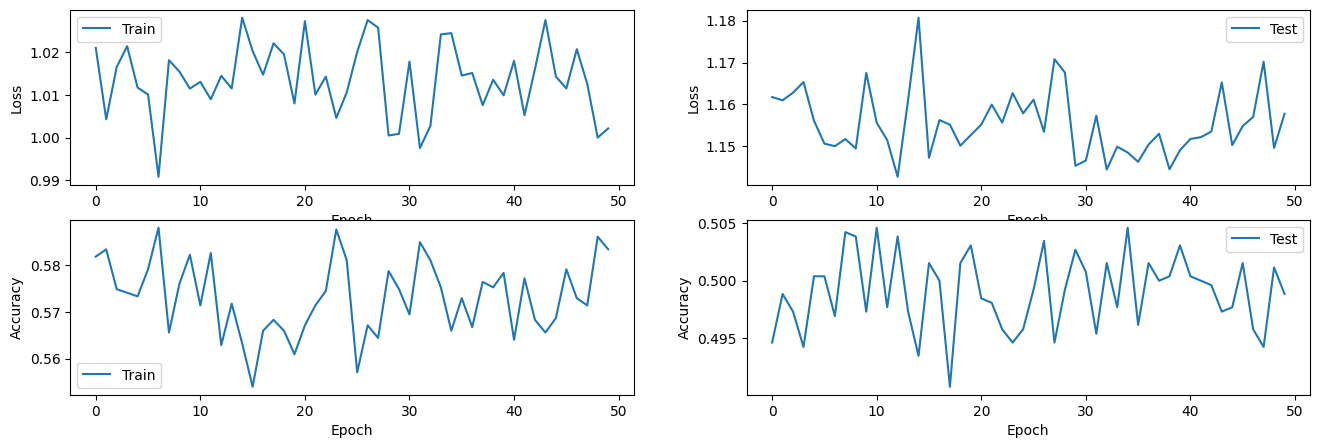

In [126]:
visualize(train_losses, test_losses, train_acc, test_acc)

# Mô hình khác

In [128]:
class HybridCNNLSTM(nn.Module):
    def __init__(self, num_classes, C=22, T=1875, F1=16, F2=32, hidden_size=64, num_layers=2):
        super(HybridCNNLSTM, self).__init__()
        
        # CNN Block
        self.conv1 = nn.Conv2d(1, F1, kernel_size=(1, 64), padding=(0, 32), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        self.conv2 = nn.Conv2d(F1, F2, kernel_size=(C, 1), bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F2)
        self.pool = nn.AvgPool2d(kernel_size=(1, 4))
        
        # LSTM Block
        self.lstm = nn.LSTM(F2, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # Bi-LSTM => 2*hidden_size

    def forward(self, x):
        # CNN Block
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = self.pool(x)
        x = x.squeeze(2)  # Remove channel dimension => (batch, F2, T')
        
        # LSTM Block
        x = x.permute(0, 2, 1)  # (batch, T', F2)
        x, _ = self.lstm(x)  # (batch, T', hidden_size * 2)
        x = x[:, -1, :]  # Take the last time step
        
        # Fully Connected Layer
        x = self.fc(x)
        return x


In [129]:
hybrid_cnn_lstm = HybridCNNLSTM(num_classes=num_classes)
hybrid_cnn_lstm = nn.DataParallel(hybrid_cnn_lstm)

optimizer = torch.optim.Adam(hybrid_cnn_lstm.parameters(), lr=lr)

In [131]:
save_path = '/kaggle/working/hybrid_cnn_lstm.pth'
train_losses, train_acc, test_losses, test_acc = train_model(hybrid_cnn_lstm, train_loader, test_loader, criterion, optimizer, save_path, device, epochs=50)

Training epoch [1/50]: 100%|██████████| 162/162 [00:03<00:00, 44.68batch/s]


	---> Loss: 1.3896
	---> Accuracy: 0.2539


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 91.10batch/s]


	---> Loss: 1.3881
	---> Accuracy: 0.2481
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.25      0.46      0.32       648
  Right Hand       0.25      0.53      0.34       648
        Foot       0.00      0.00      0.00       648
      Tongue       0.00      0.00      0.00       648

    accuracy                           0.25      2592
   macro avg       0.12      0.25      0.17      2592
weighted avg       0.12      0.25      0.17      2592

Model is saved to  /kaggle/working/hybrid_cnn_lstm.pth


Training epoch [2/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [2/50]: 100%|██████████| 162/162 [00:03<00:00, 48.55batch/s]


	---> Loss: 1.3864
	---> Accuracy: 0.2593


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 89.40batch/s]


	---> Loss: 1.3911
	---> Accuracy: 0.2477
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.33      0.00      0.01       648
  Right Hand       0.24      0.06      0.09       648
        Foot       0.25      0.40      0.30       648
      Tongue       0.25      0.53      0.34       648

    accuracy                           0.25      2592
   macro avg       0.27      0.25      0.19      2592
weighted avg       0.27      0.25      0.19      2592



Training epoch [3/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [3/50]: 100%|██████████| 162/162 [00:03<00:00, 48.22batch/s]


	---> Loss: 1.3858
	---> Accuracy: 0.2589


Evaluating:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Evaluating: 100%|██████████| 162/162 [00:01<00:00, 91.46batch/s]


	---> Loss: 1.3914
	---> Accuracy: 0.2473
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.23      0.12      0.16       648
  Right Hand       0.25      0.56      0.35       648
        Foot       0.00      0.00      0.00       648
      Tongue       0.25      0.30      0.27       648

    accuracy                           0.25      2592
   macro avg       0.18      0.25      0.20      2592
weighted avg       0.18      0.25      0.20      2592



Training epoch [4/50]:   0%|          | 0/162 [00:00<?, ?batch/s]/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
Training epoch [4/50]:  98%|█████████▊| 158/162 [00:03<00:00, 44.15batch/s]


KeyboardInterrupt: 